## 0.0. IMPORTS

In [69]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime, timedelta
from matplotlib import gridspec
from scipy import stats
from scipy.stats import chi2
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

## 0.1. Helper Functions

In [70]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 -(k-1)*(r-1)/(n-1)) #bias correction
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    

def jupyter_setting():
    %matplotlib_inline
    %pylab_inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

## 0.2. Loading Data

In [71]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 1.0. DESCRICAO DOS DADOS

In [72]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [73]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [74]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [75]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [76]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [77]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA


In [78]:
df1['competition_distance'].max()

75860.0

In [79]:
# competition_distance      
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0  if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2
# promo2_since_week
df1['promo2_since_week']= df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year
df1['promo2_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [80]:
df1.sample(30)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
752340,501,1,2013-08-26,7335,703,1,1,0,1,a,c,1620.0,9.0,2006.0,0,35.0,2013.0,0,Aug,0
12435,171,1,2015-07-20,7517,724,1,0,0,1,a,a,2640.0,7.0,2015.0,0,30.0,2015.0,0,Jul,0
512674,560,6,2014-03-29,12793,1655,1,0,0,0,c,c,1910.0,7.0,2013.0,0,13.0,2014.0,0,Mar,0
651642,153,7,2013-11-24,0,0,0,0,0,0,a,a,16240.0,10.0,2000.0,1,18.0,2011.0,"Feb,May,Aug,Nov",Nov,1
485951,597,2,2014-04-22,4846,768,1,0,0,1,a,a,150.0,9.0,2008.0,1,1.0,2012.0,"Mar,Jun,Sept,Dec",Apr,0
287125,312,5,2014-11-07,6994,641,1,1,0,0,d,a,11300.0,3.0,2012.0,0,45.0,2014.0,0,Nov,0
486214,860,2,2014-04-22,4975,706,1,0,0,0,c,c,5980.0,2.0,2010.0,0,17.0,2014.0,0,Apr,0
44595,1111,1,2015-06-22,4814,387,1,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",Jun,0
849286,442,5,2013-05-31,6876,579,1,1,0,1,c,a,500.0,5.0,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov",May,1
357703,849,7,2014-08-24,0,0,0,0,0,1,c,c,5000.0,8.0,2014.0,0,34.0,2014.0,0,Aug,0


In [81]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [82]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7. Descriptive Statistics

In [83]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [84]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()

m.columns = ['attributes','min','max','range','mean','median', 'std', 'skew', 'kurtosis']

In [85]:
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2. Categorical Attributes

In [86]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

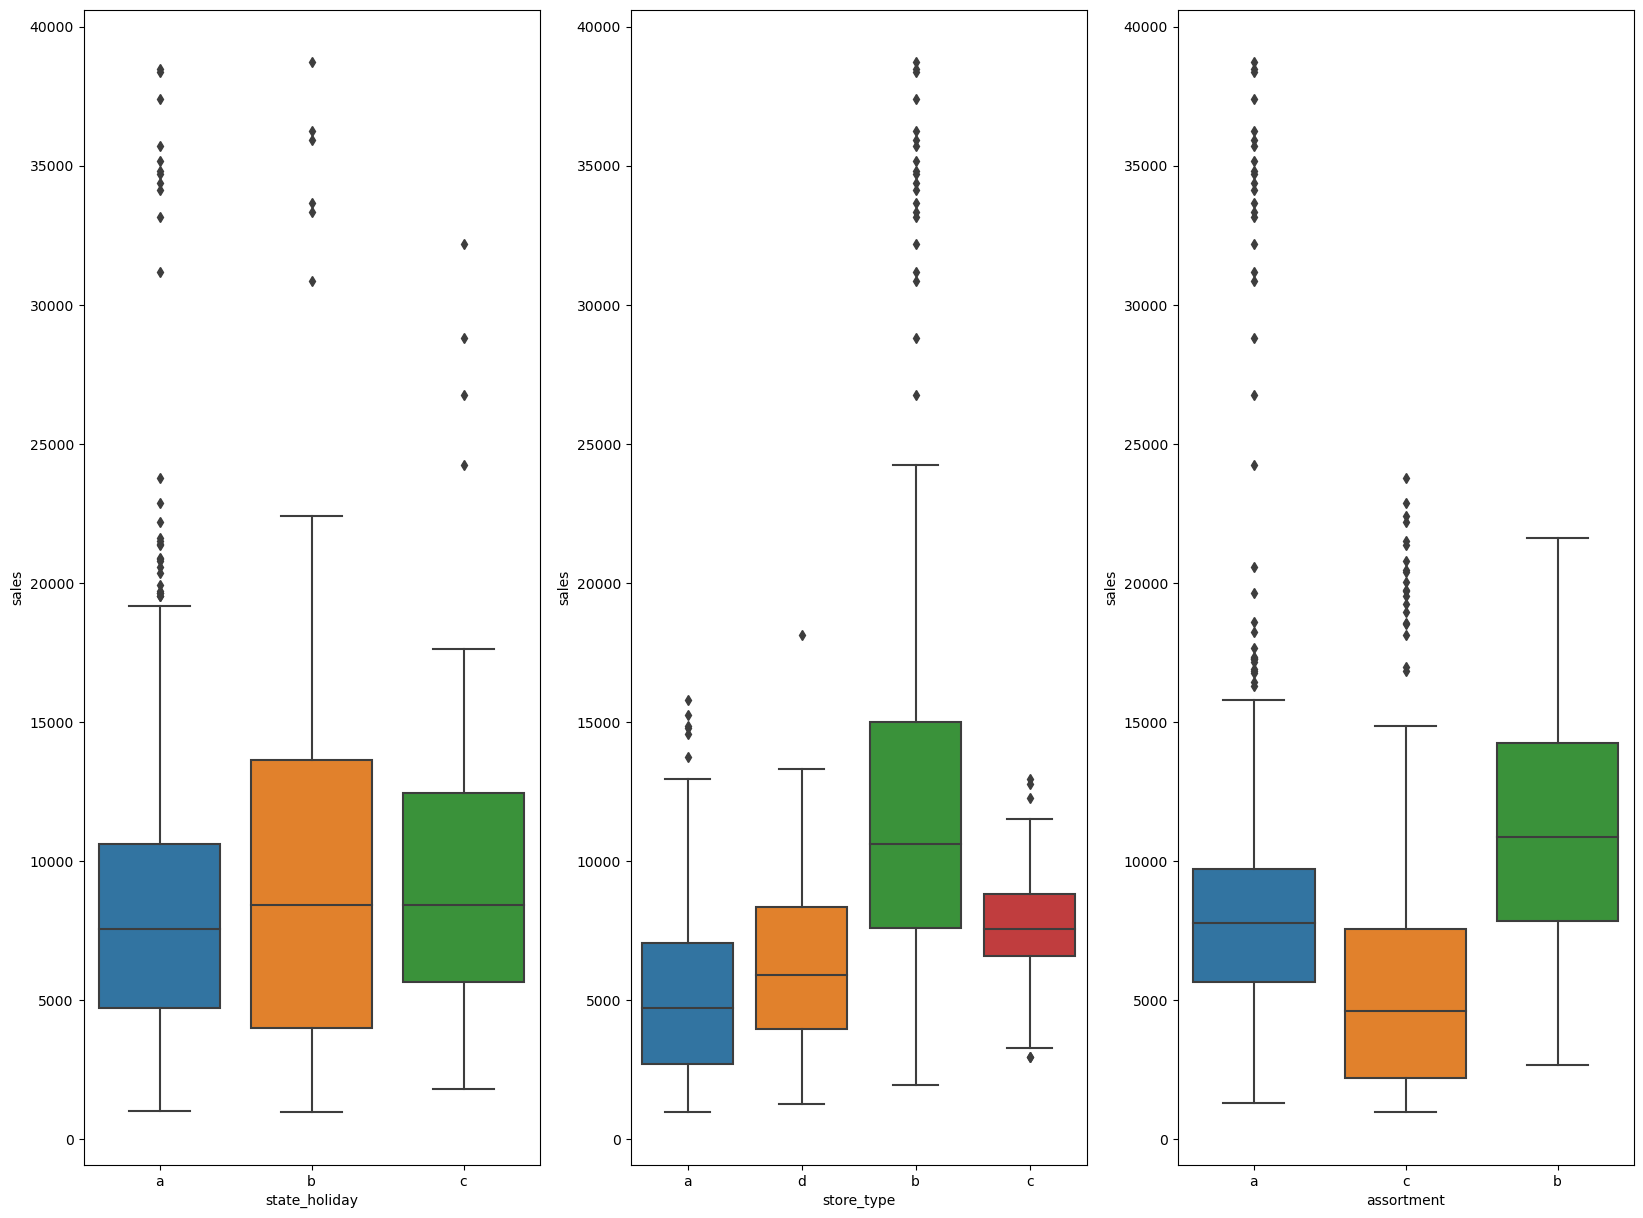

In [87]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

## 2.0. Feature Engineering

In [88]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

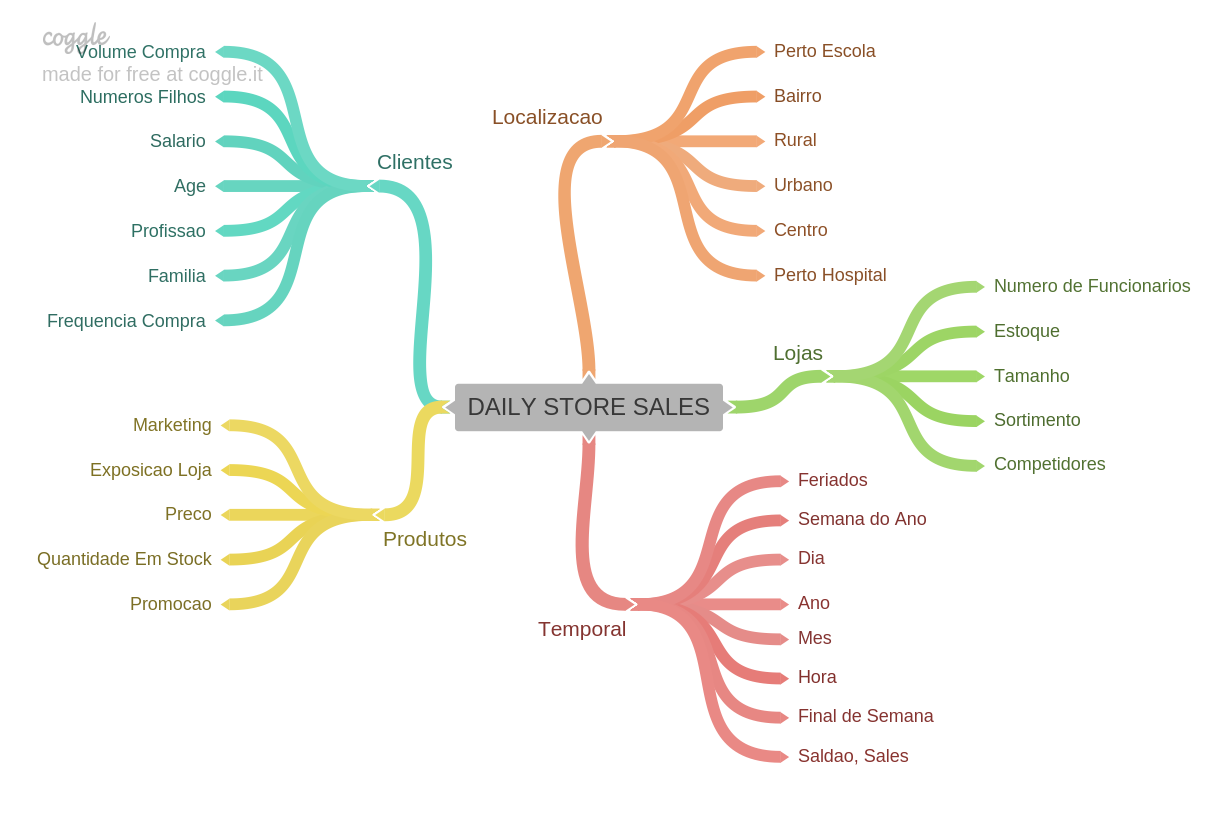

In [89]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.1.1. Store Hypothesis

** 1.** Stores with a higher number of employees should sell more.

** 1.** Stores with a larger inventory capacity should sell more.

** 1.** Larger stores should sell more.

** 1.** Stores with a wider variety of products should sell more.

** 1.** Stores with closer competitors should sell less.

** 1.** Stores with competitors for a longer time should sell more.

### 2.1.2.  Product Hypothesis

** 1. ** Stores that invest more in marketing should sell more.

** 2. ** Stores with greater product exposure should sell more.

** 3. ** Stores with lower priced products should sell more.

** 5. ** Stores with more aggressive promotions (higher discounts) should sell more.

** 6. ** Stores with promotions active for a longer time should sell more.

** 7. ** Stores with more promotional days should sell more.

** 8. ** Stores with more consecutive promotions should sell more.

### 2.1.3. Time Hypothesis

** 1. ** Stores that are open during the Christmas holiday should sell more.

** 2. ** Stores should sell more over the years.

** 3. ** Stores should sell more during the second semester of the year.

** 4. ** Stores should sell more after the 10th of each month.

** 5. ** Stores should sell less on weekends.

** 6. ** Stores should sell less during school holidays.

## 2.2. Hypothesis Final List

** 1. ** Stores with a wider variety of products should sell more.

** 2. ** Stores with closer competitors should sell less.

** 3. ** Stores with competitors for a longer time should sell more.

** 4. ** Stores with promotions active for a longer time should sell more.

** 5. ** Stores with more promotional days should sell more.

** 7. ** Stores with more consecutive promotions should sell more.

** 8. ** Stores that are open during the Christmas holiday should sell more.

** 9. ** Stores should sell more over the years.

** 10. ** Stores should sell more during the second semester of the year.

** 11. ** Stores should sell more after the 10th of each month.

** 12. ** Stores should sell less on weekends.

** 13. ** Stores should sell less during school holidays.

## 2.3. Feature Engineering

In [90]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since']= df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week']= ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

 

/var/folders/jy/fvwm432958vcp25bqxf18ttw0000gn/T/ipykernel_2170/3004214640.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. Variable Filtering

In [91]:
df3 = df2.copy()

In [92]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1. Rows Filtering

In [93]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [94]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1)

In [95]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis

In [96]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

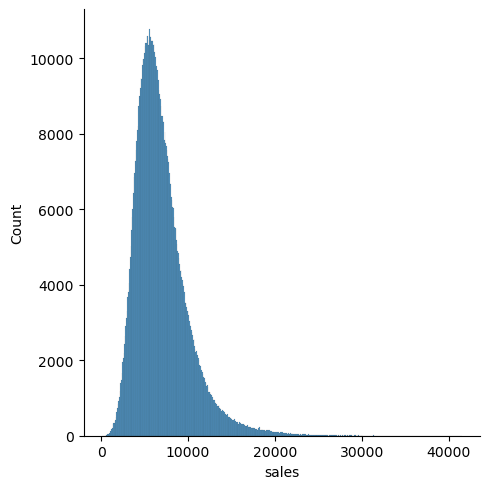

In [97]:
sns.displot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

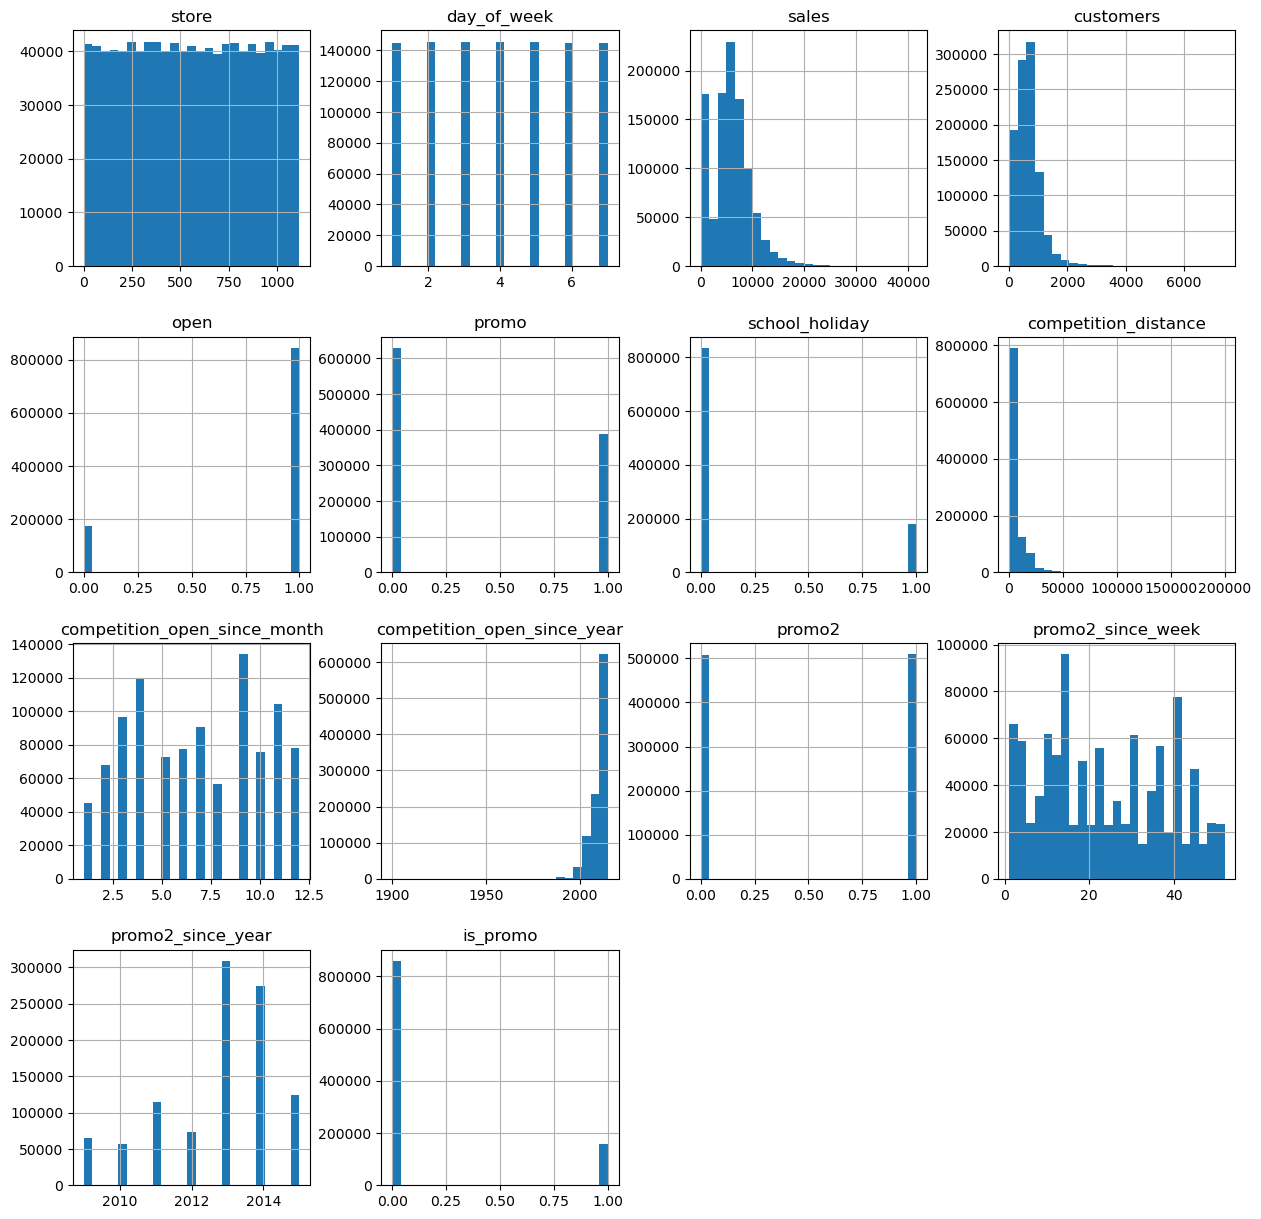

In [98]:
num_attributes.hist(bins=25, figsize=(15, 15));

### 4.1.3. Categorical Variable

In [99]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

In [100]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot: xlabel='sales', ylabel='Density'>

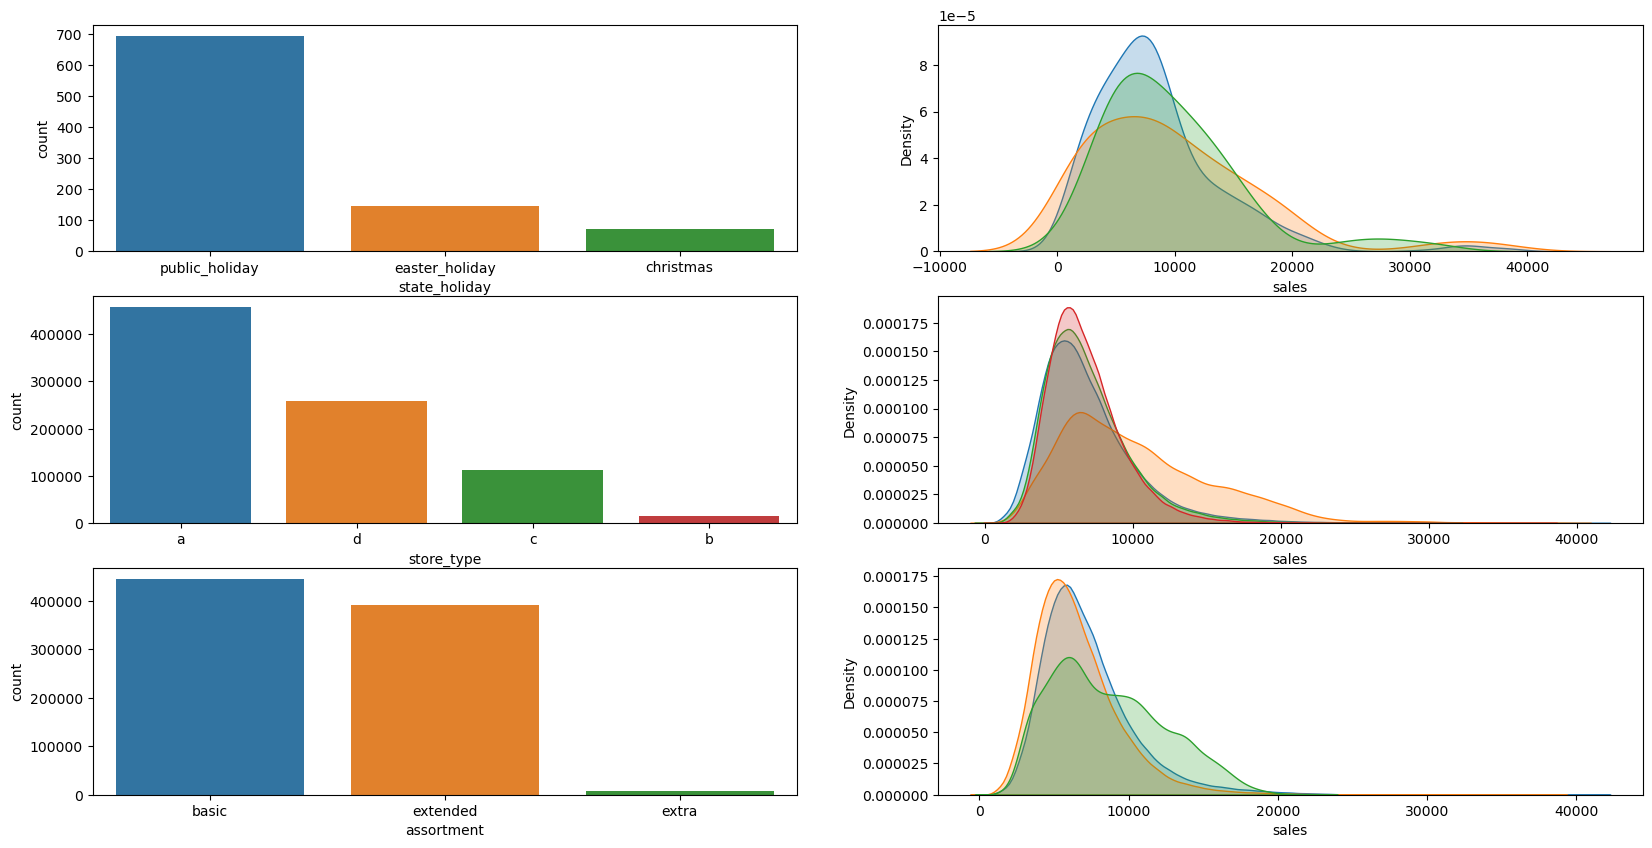

In [101]:
# state_holiday
plt.figure(figsize=(20,10))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = 'state_holiday',
              data = a,
              order = a['state_holiday'].value_counts().index)


plt.subplot(3, 2, 2)

sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', fill=True)

sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', fill=True)

sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x = 'store_type',
              data = df4,
              order = df4['store_type'].value_counts().index)


plt.subplot(3, 2, 4)

sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a', fill=True)

sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b', fill=True)

sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c', fill=True)

sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d', fill=True)

# assortment

plt.subplot(3, 2, 5)
sns.countplot(x = 'assortment',
              data = df4,
              order = df4['assortment'].value_counts().index)


plt.subplot(3, 2, 6)

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='extended', fill=True)

sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='basic', fill=True)

sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='extra', fill=True)


## 4.2. Bivariate Analysis

#### H1. Stores with a wider variety of products should sell more. 
###### False -> Stores with a WIDER VARIETY of products sell LESS

[]

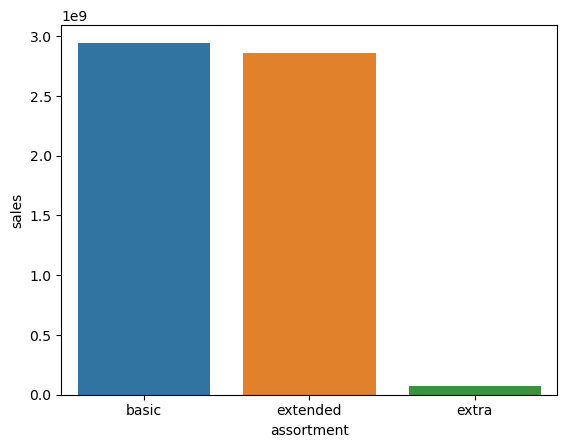

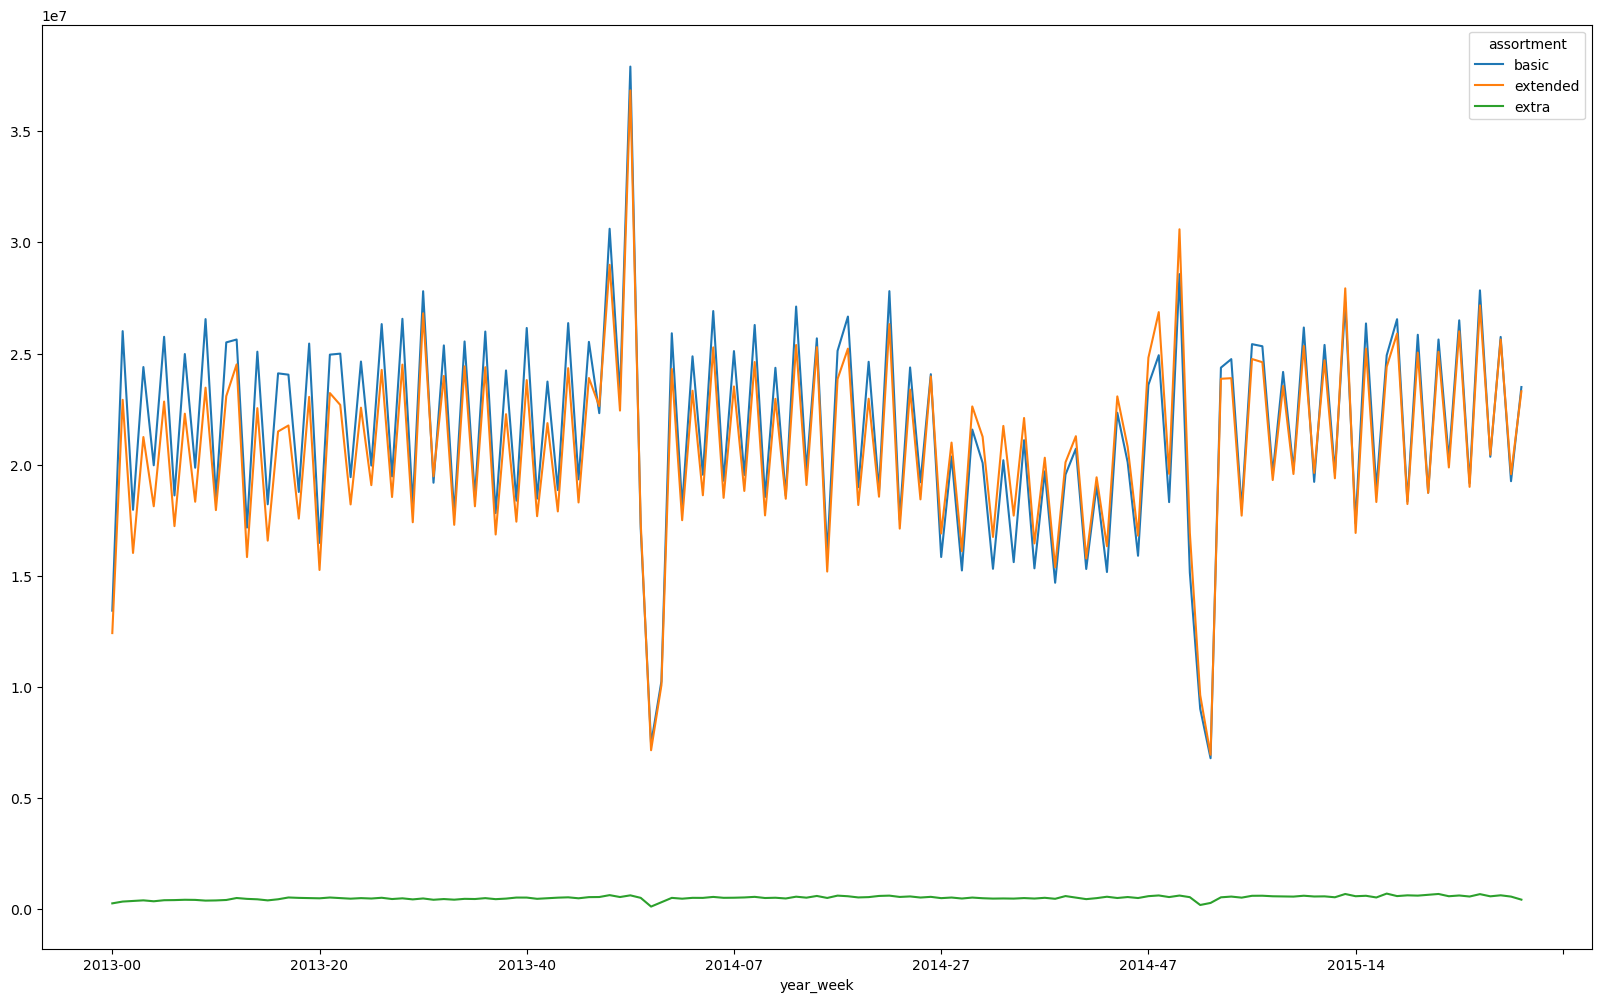

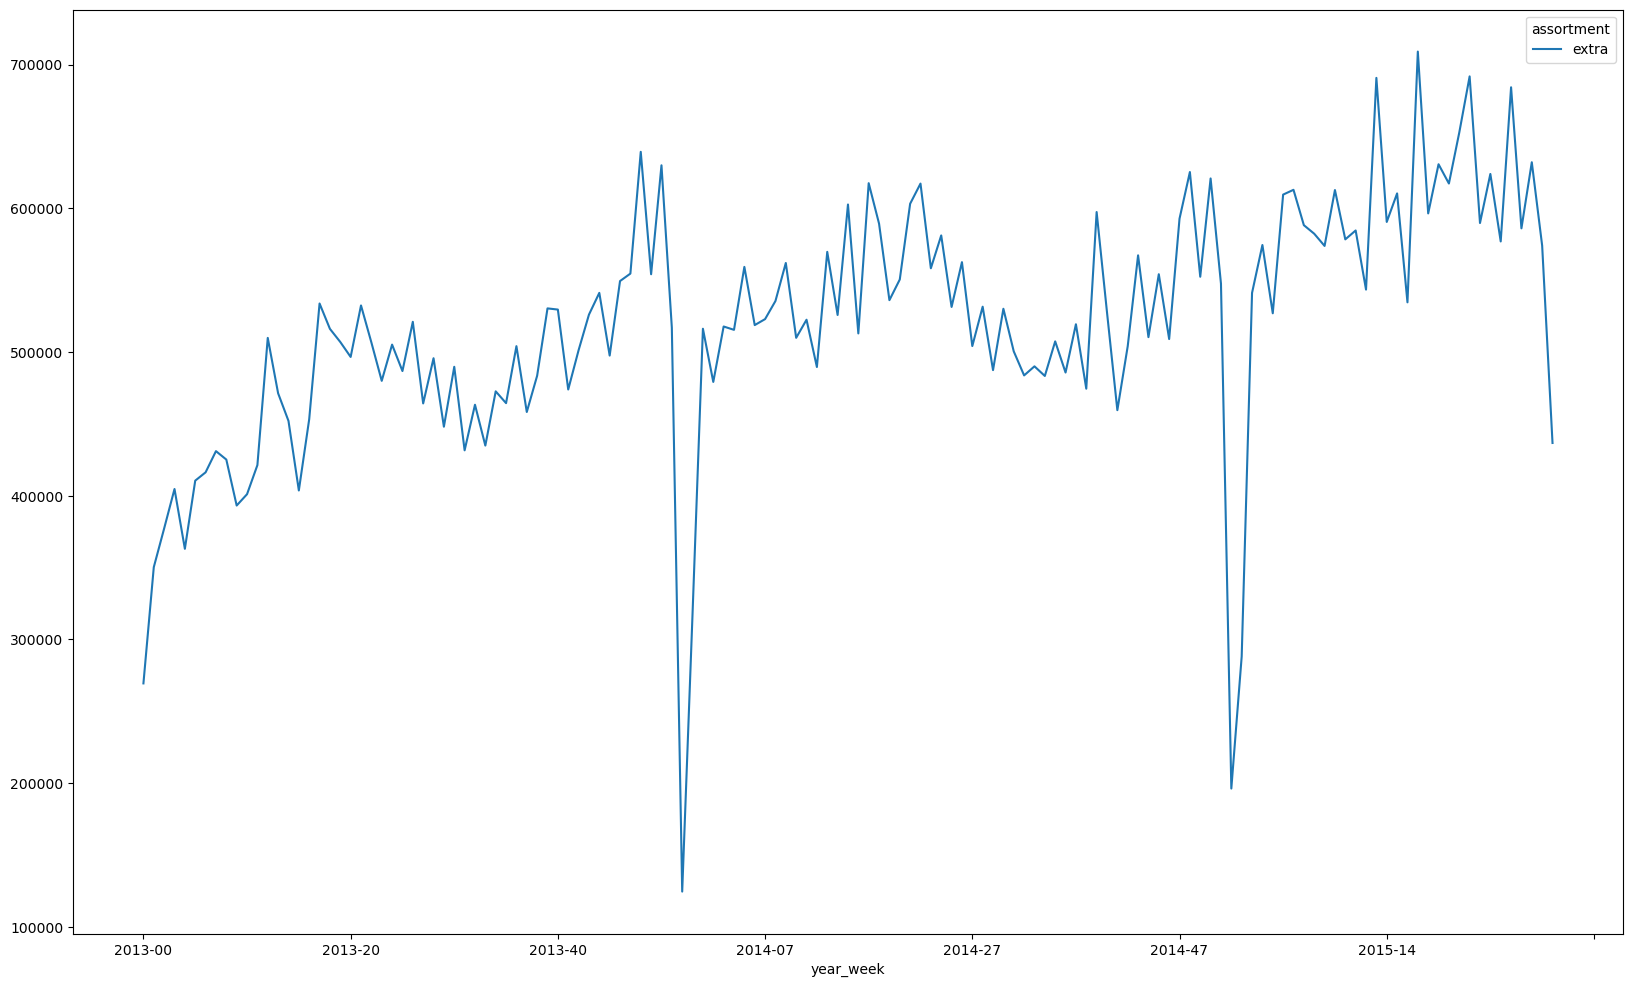

In [102]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y= 'sales', data=aux1);

aux2 = df4[['year_week' ,'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(20,12))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(20,12)).plot()

##### H2. Stores with closer competitors should sell less.
###### FALSE -> Stores with CLOSER COMPETITORS sell MORE

/var/folders/jy/fvwm432958vcp25bqxf18ttw0000gn/T/ipykernel_2170/347418191.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


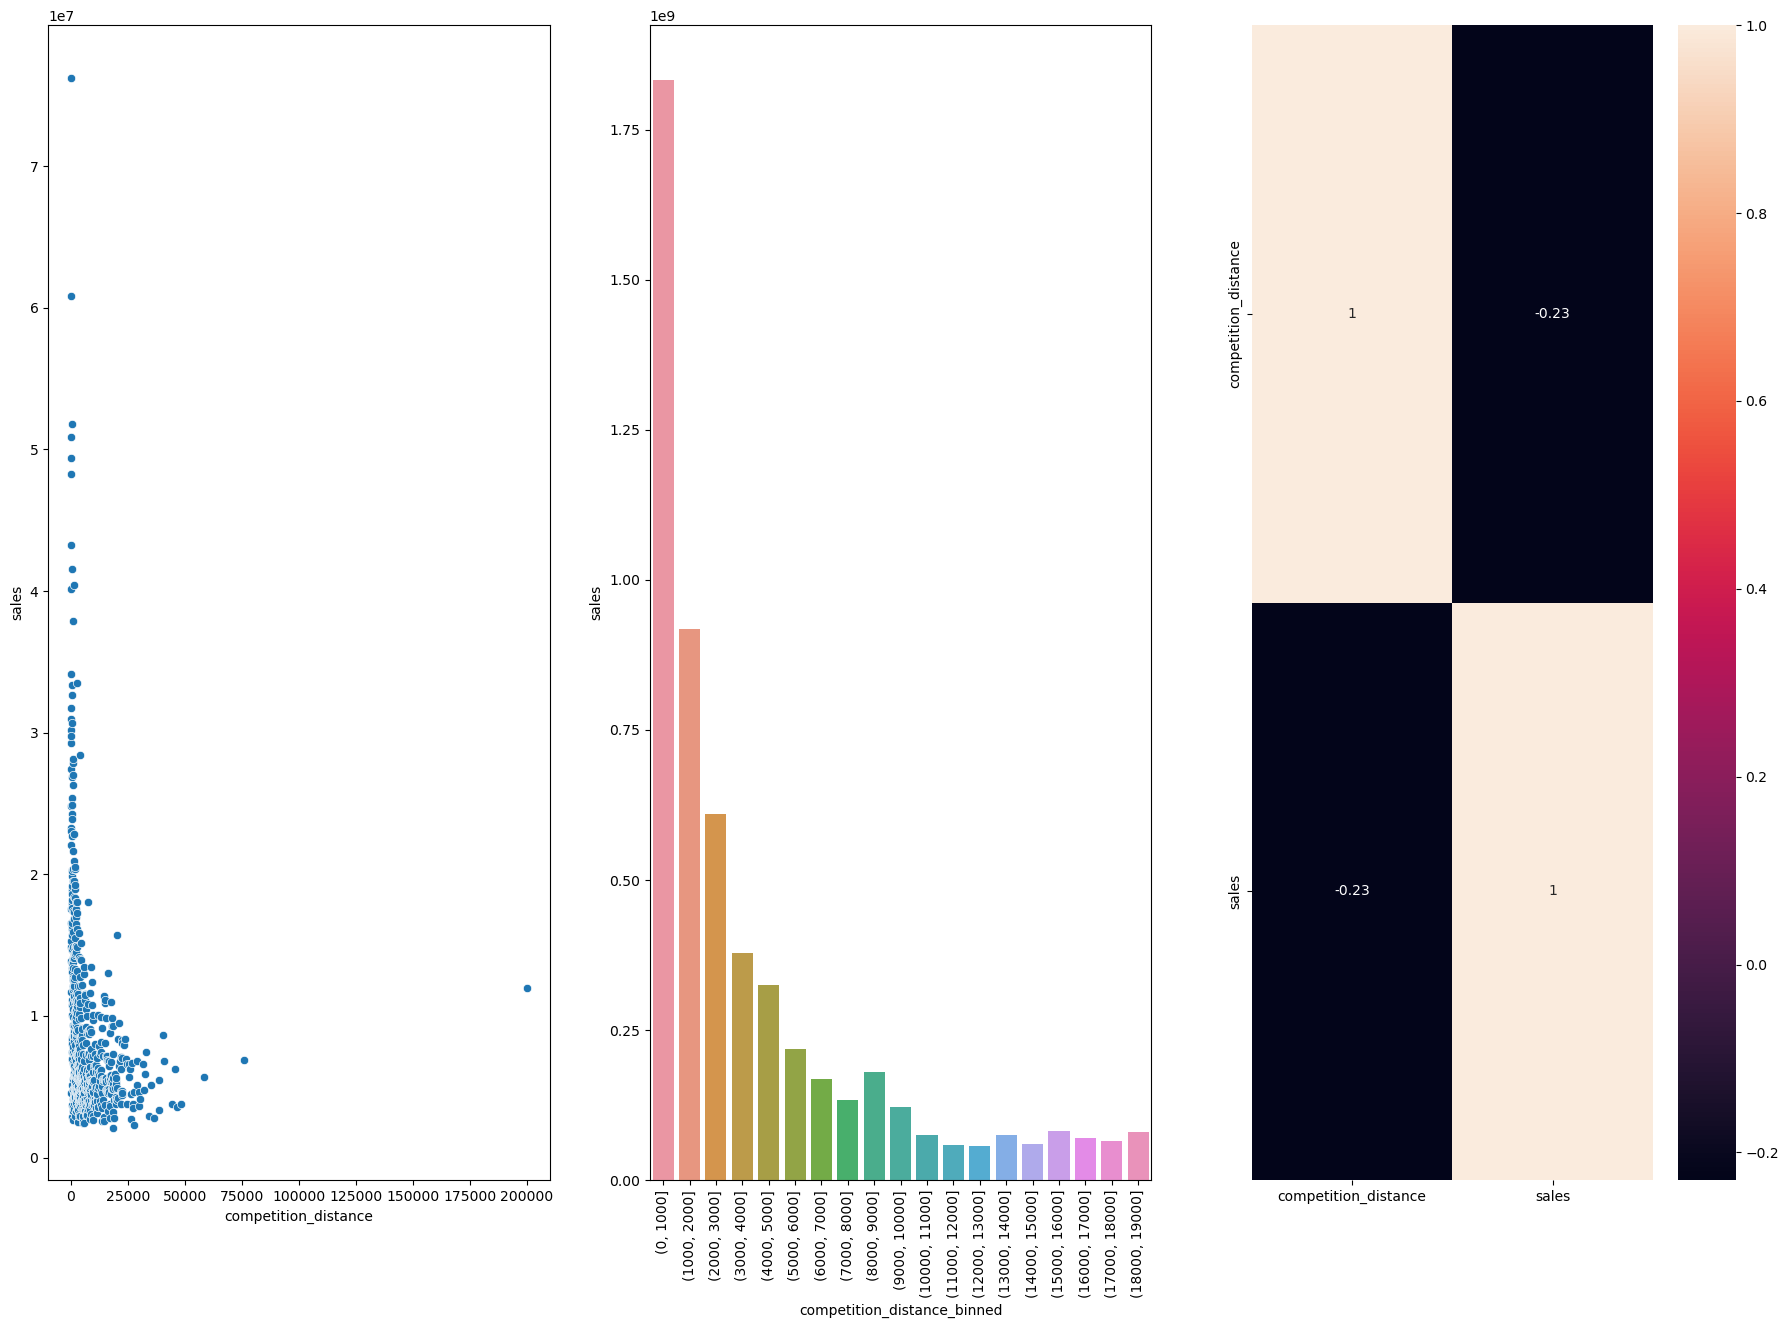

In [103]:
plt.figure(figsize=(22,15))
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)


sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


##### H3. Stores with competitors for a longer time should sell more.
##### FALSE -> Stores with COMPETITORS FOR A LONGER TIME sell LESS

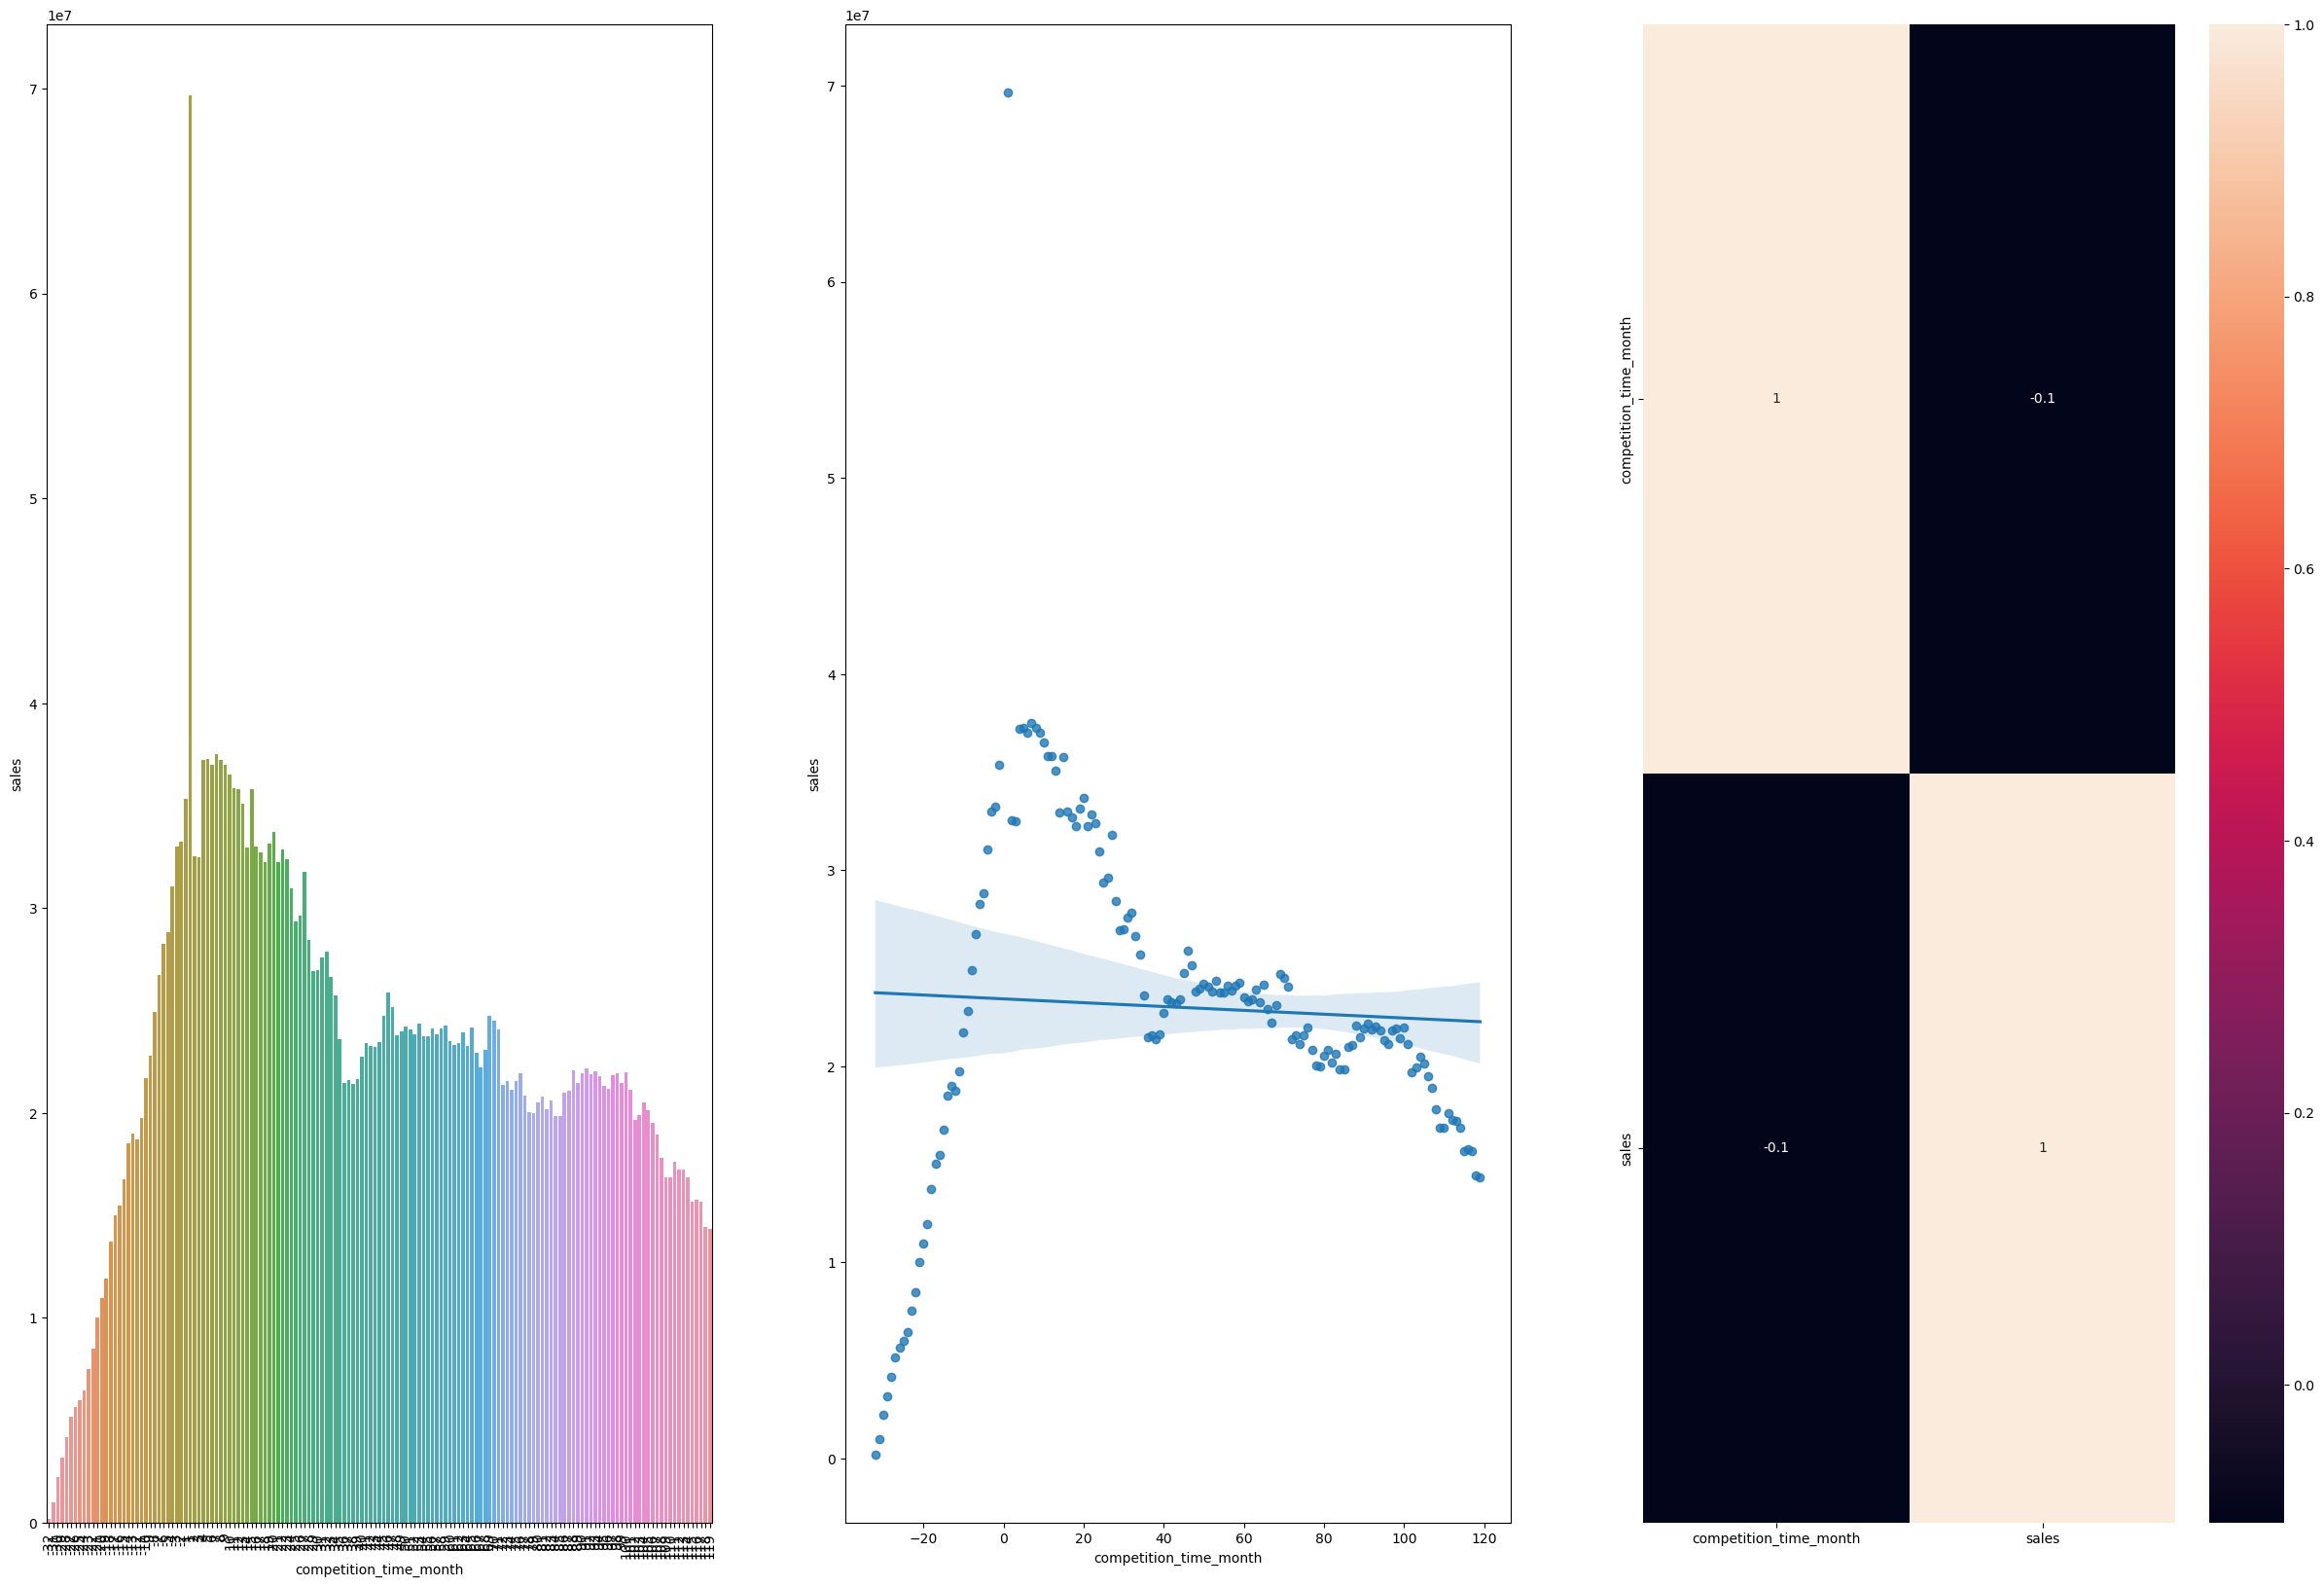

In [104]:
plt.figure(figsize=(30,20))
plt.subplot(1,3,1)

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month']!= 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#biased, non linear
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### H4. Stores with promotions active for a longer time should sell more.
#### FALSE -> Store with promotions active for a longer time SELL LESS, after a certain period.

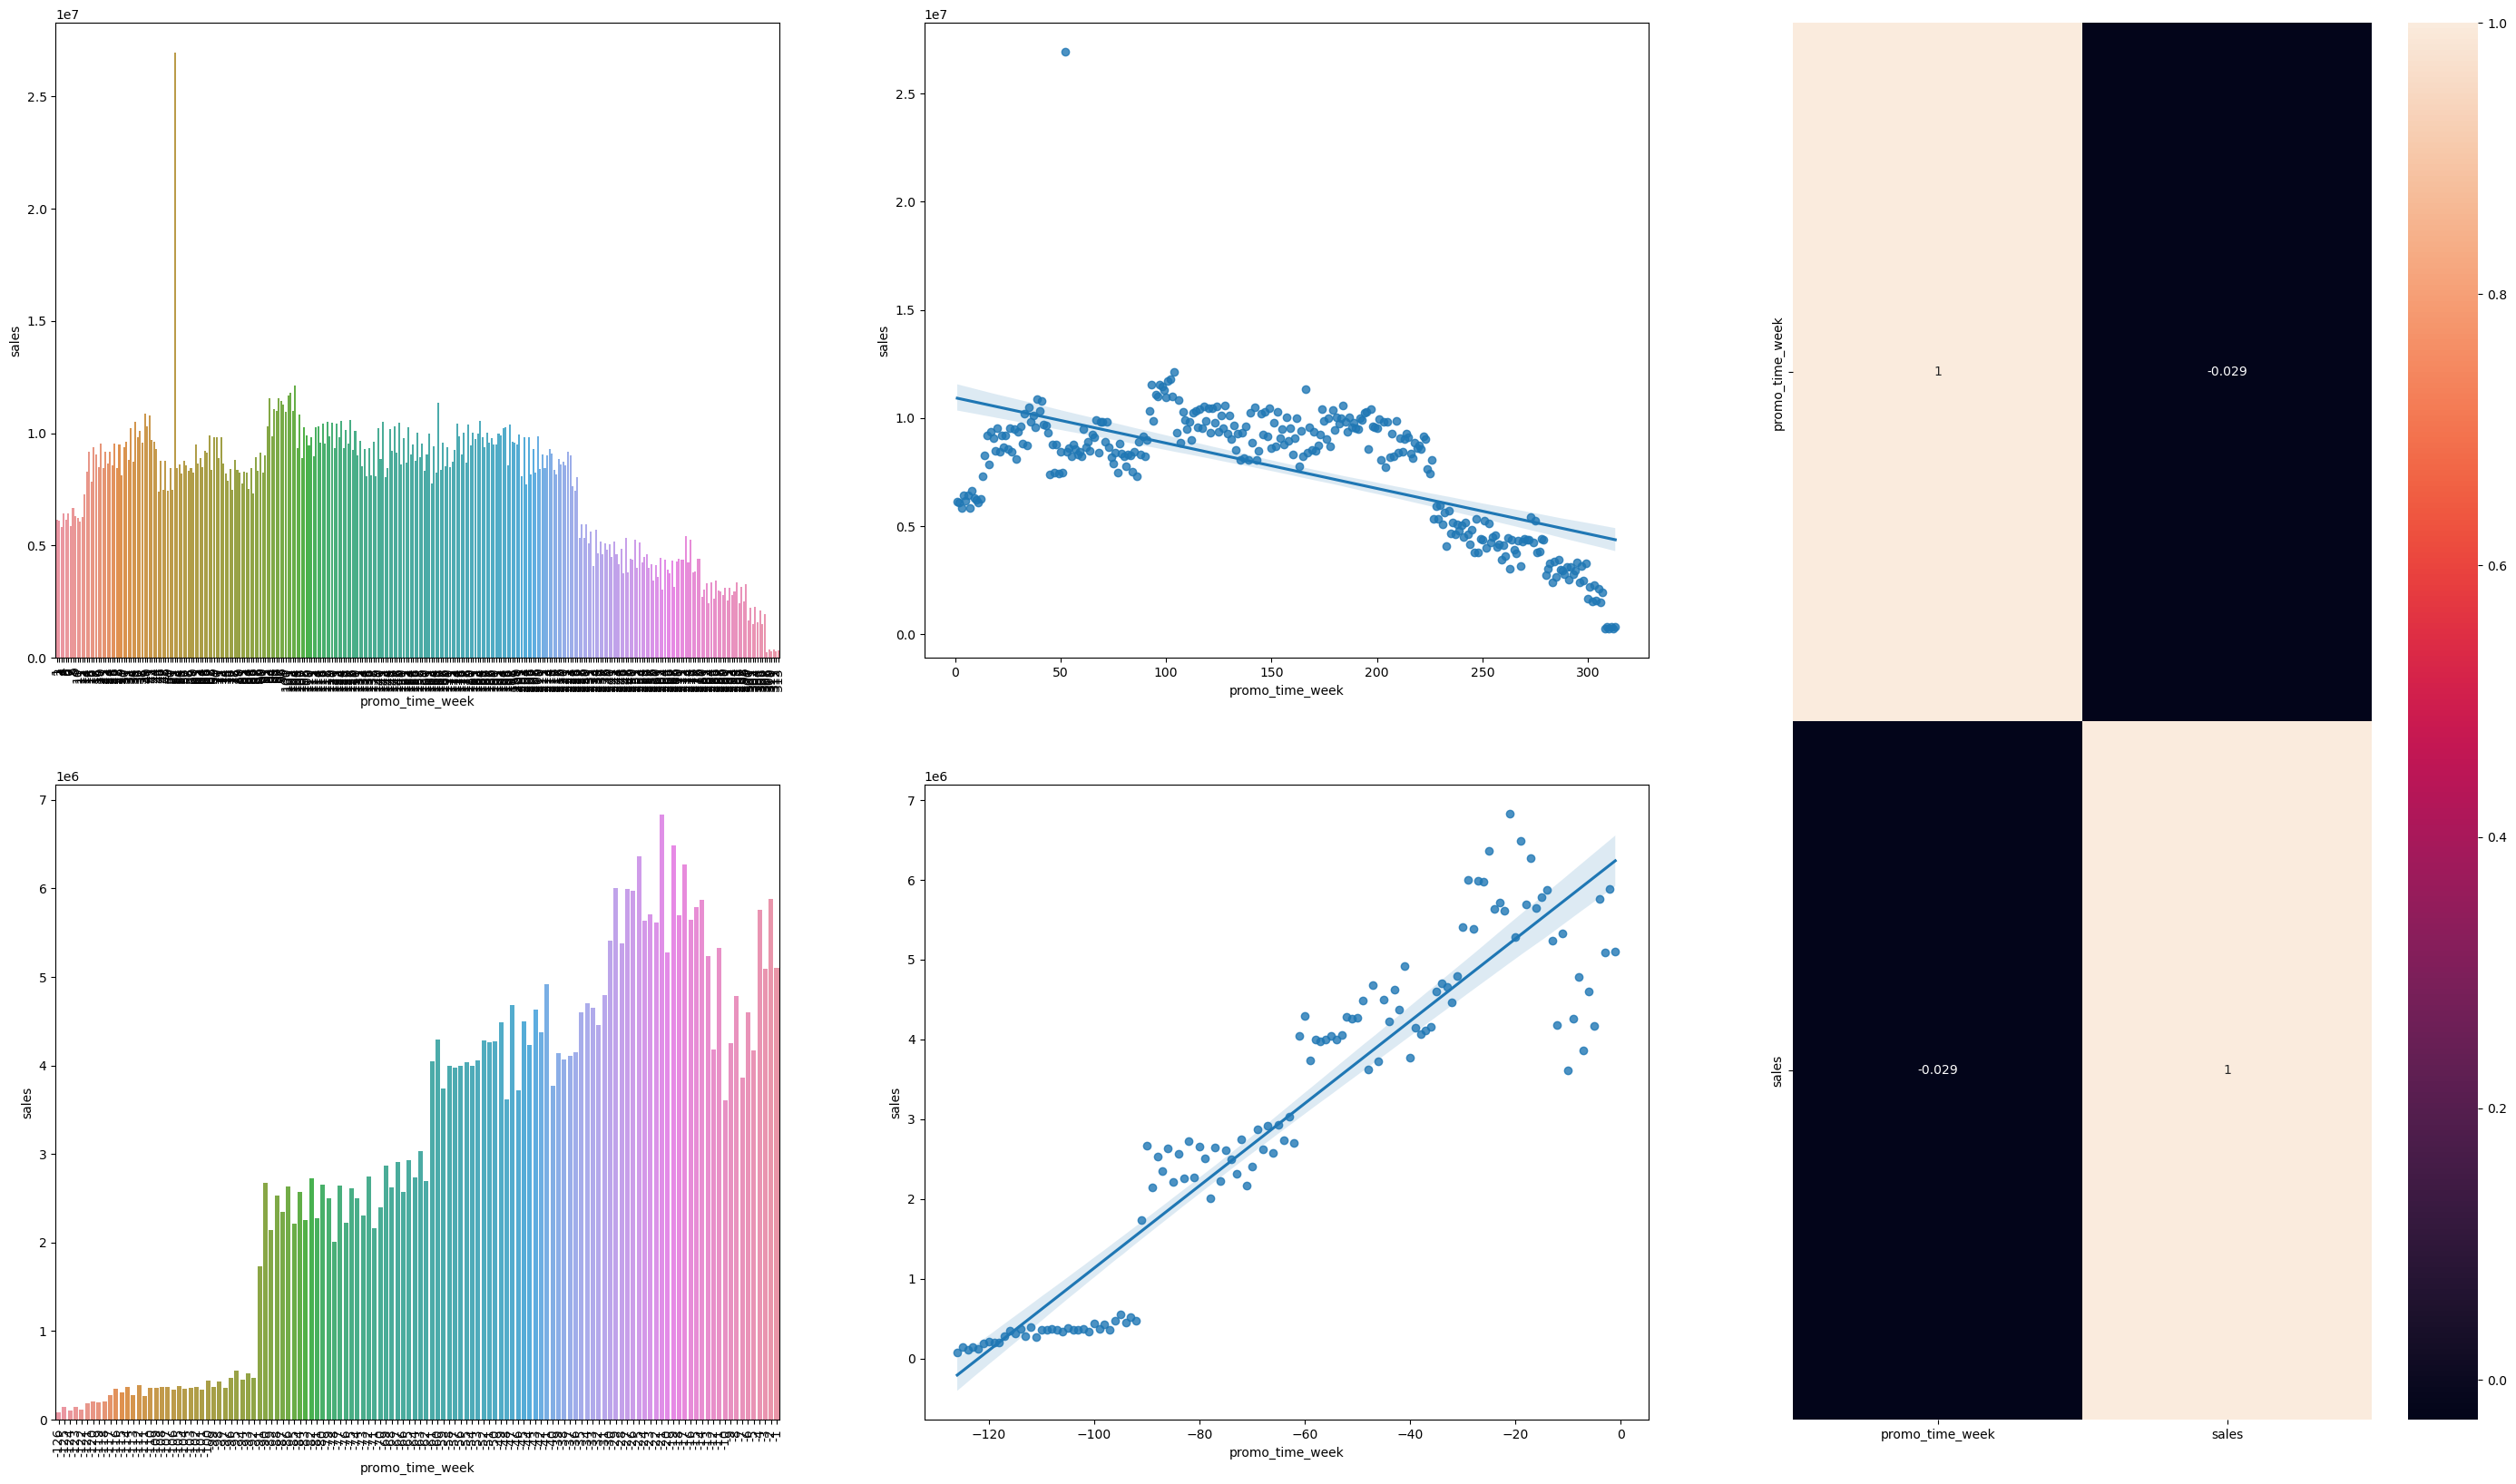

In [105]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.figure(figsize=(35,20))
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extended
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### <s> H5. Stores with more promotional days should sell more. </s>

#### H6. Stores with more consecutive promotions should sell more.
#### FALSE -> Stores with more consecutives promotions SELL LESS.

In [106]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


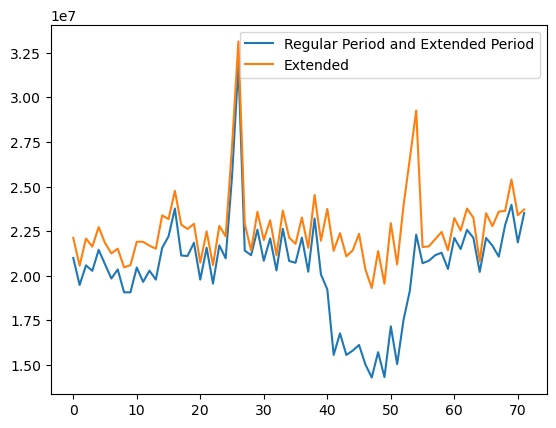

In [107]:

aux1 = df4[(df4['promo'] == 1) & (df4['promo2']== 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 =  aux1 = df4[(df4['promo'] == 1) & (df4['promo2']== 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels =['Regular Period and Extended Period', 'Extended']);

#### H7. Stores that are open during the Christmas holiday should sell more.
#### FALSE -> Stores that are open during the Christmas holiday SELL LESS.

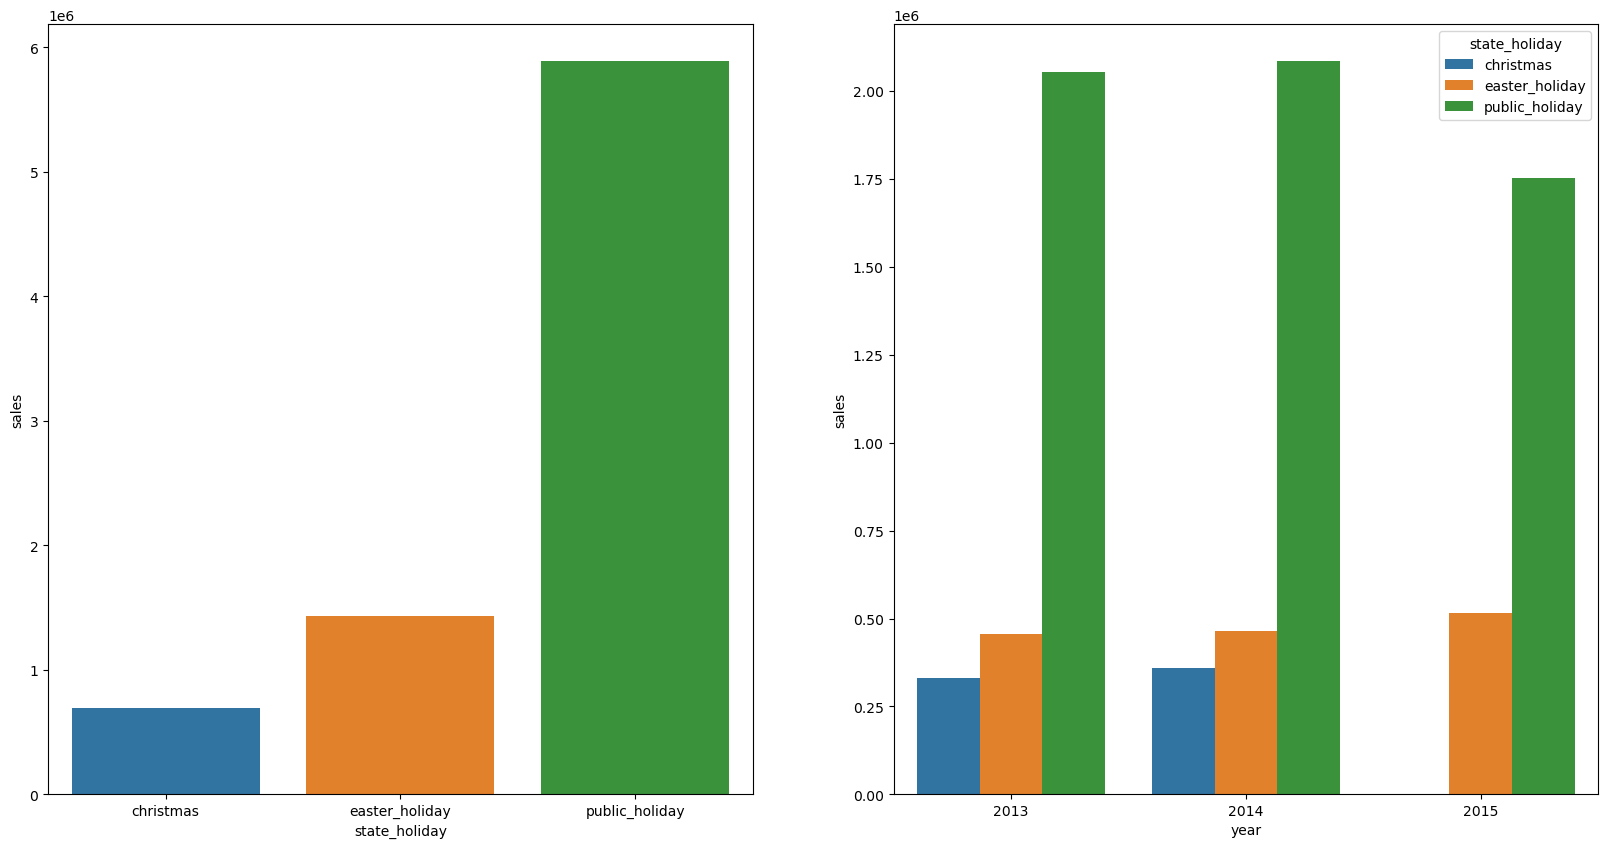

In [108]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#### H8. Stores should sell more over the years.
#### FALSE -> Stores SELL LESS over the years.


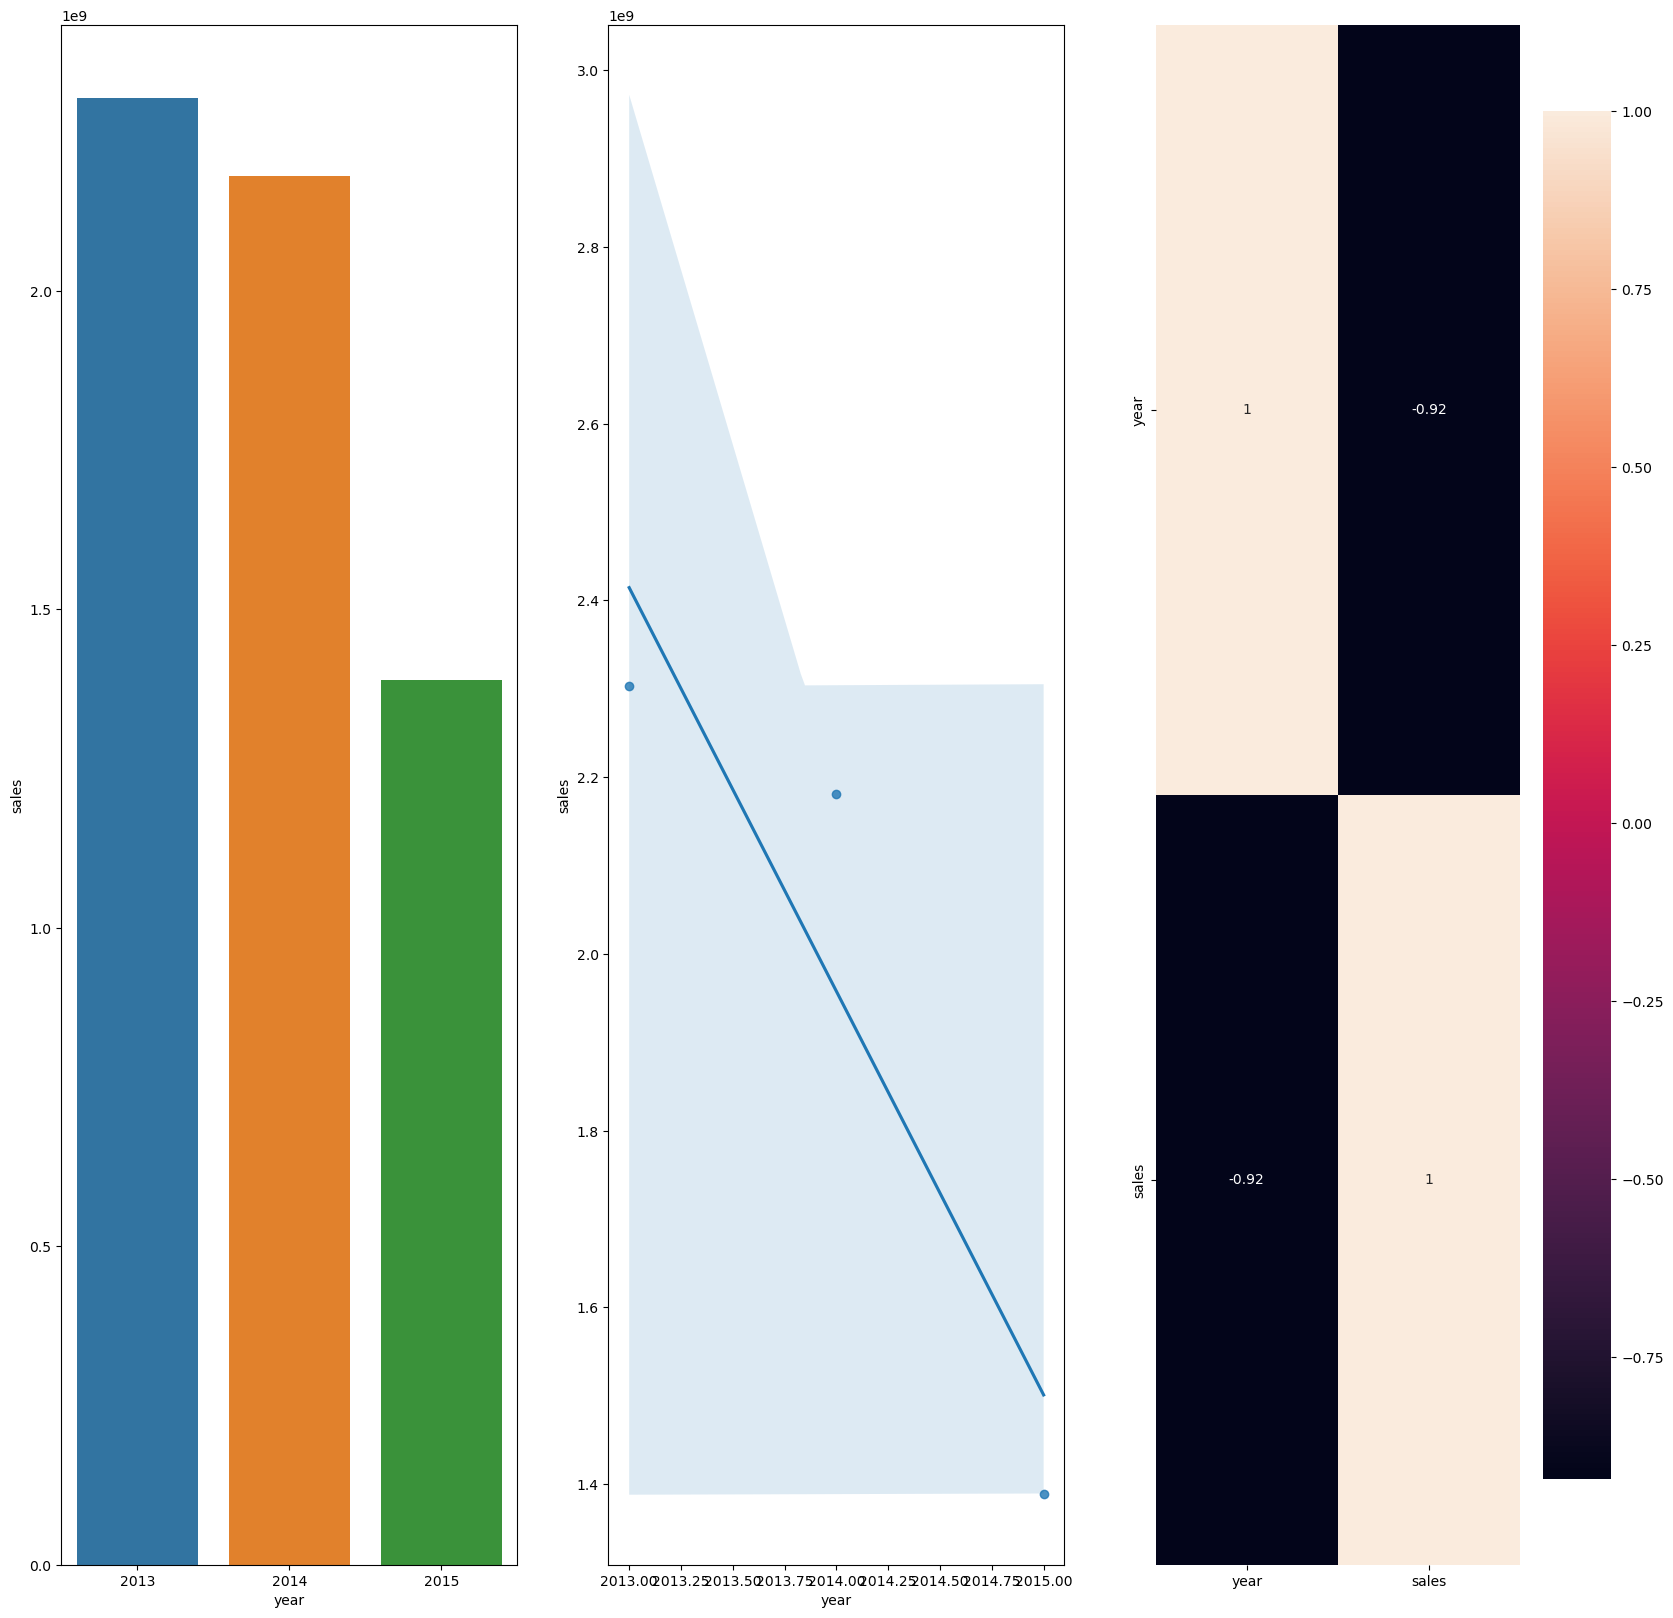

In [109]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H9. Stores should sell more during the second semester of the year.

#### FALSE -> Store SELL LESS during the second semestes of the year.

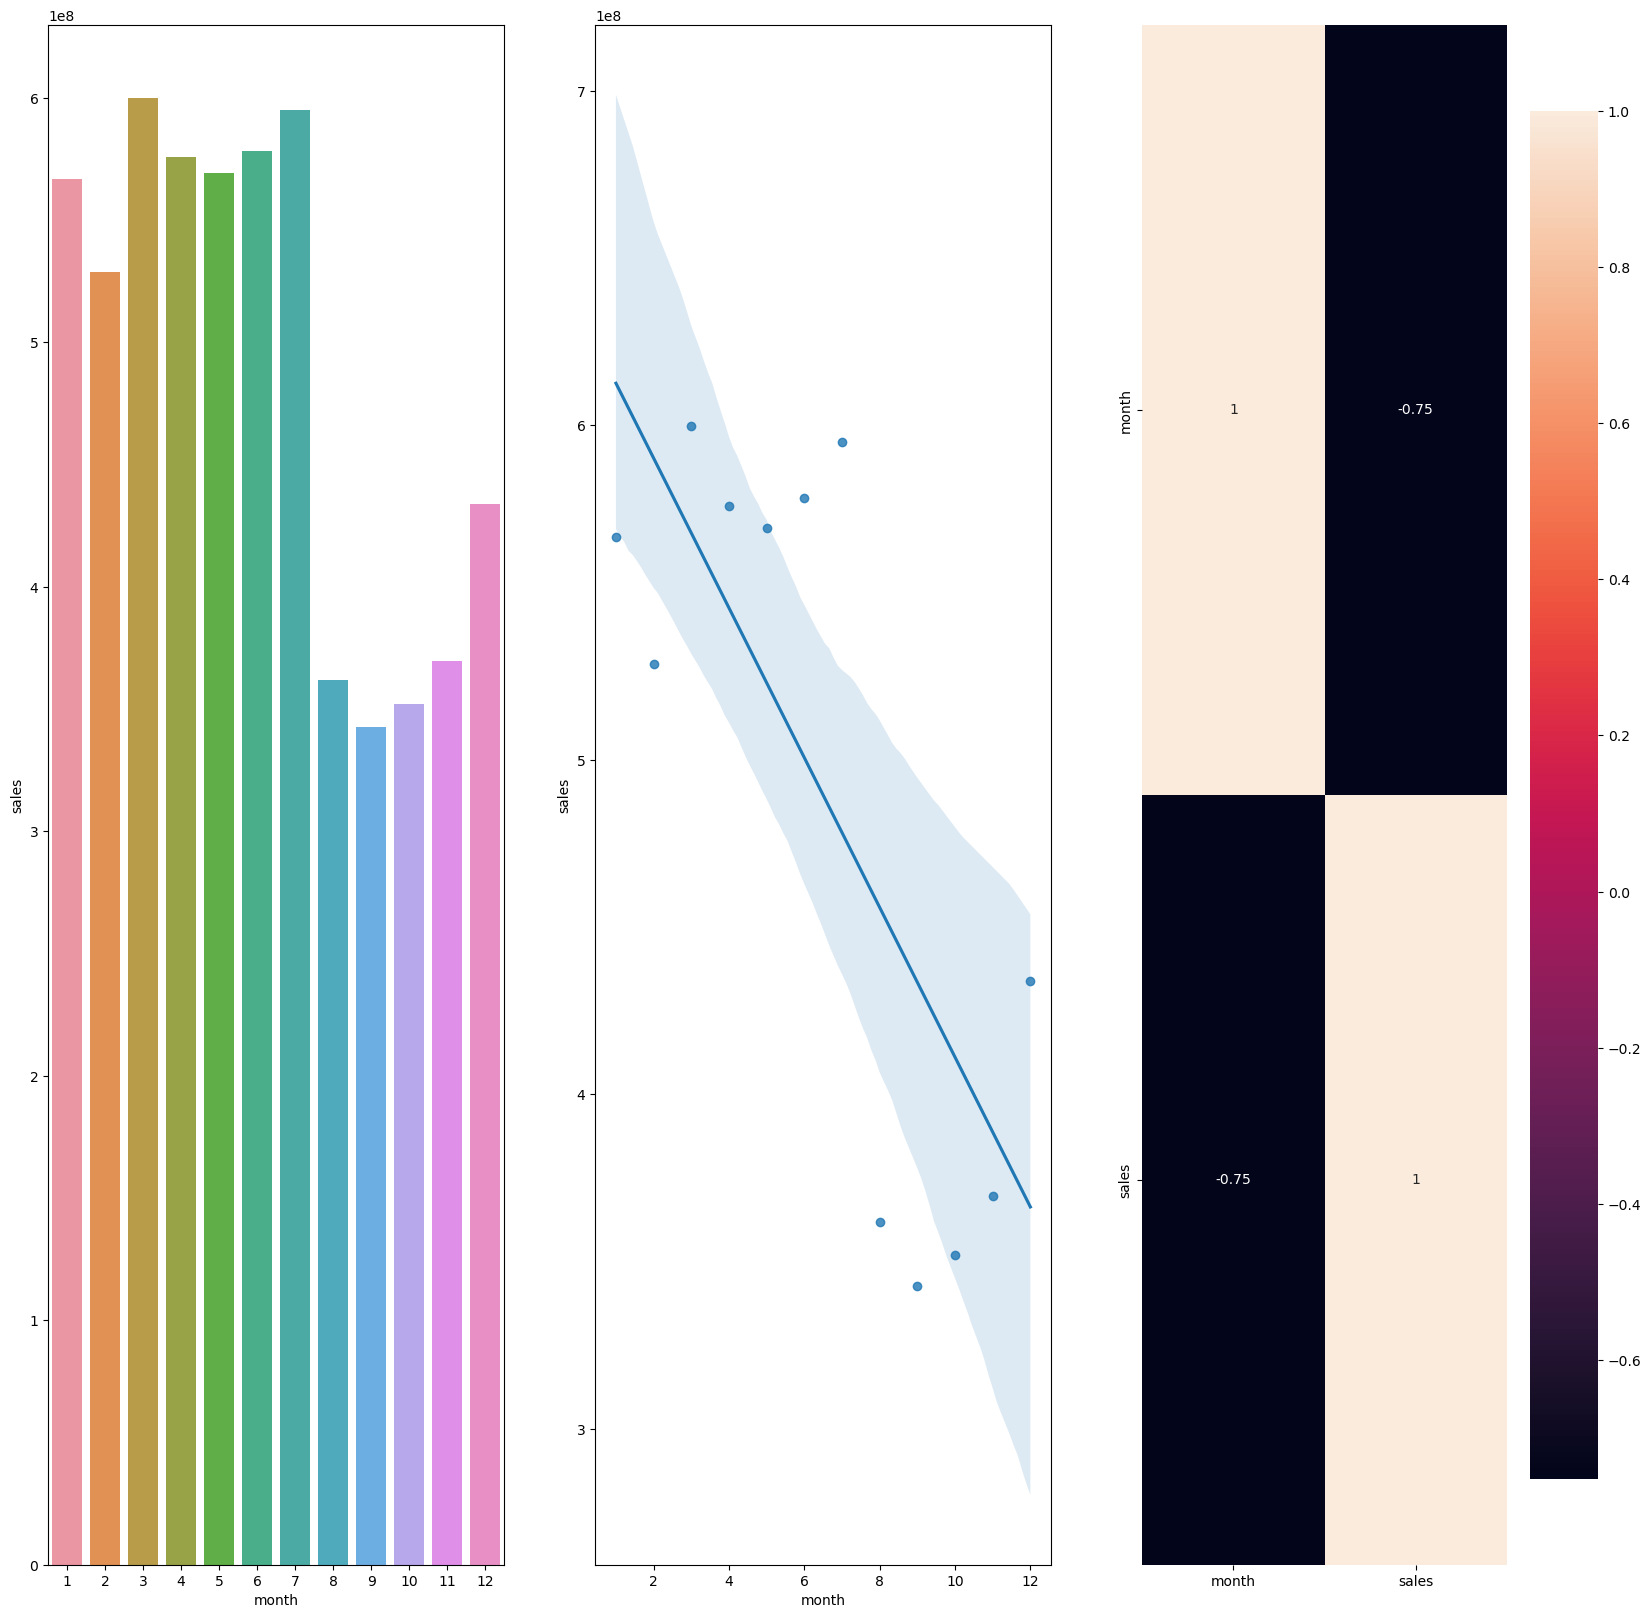

In [110]:

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H10. Stores should sell more after the 10th of each month.

#### TRUE -> Store sell more after the 10th of each month.

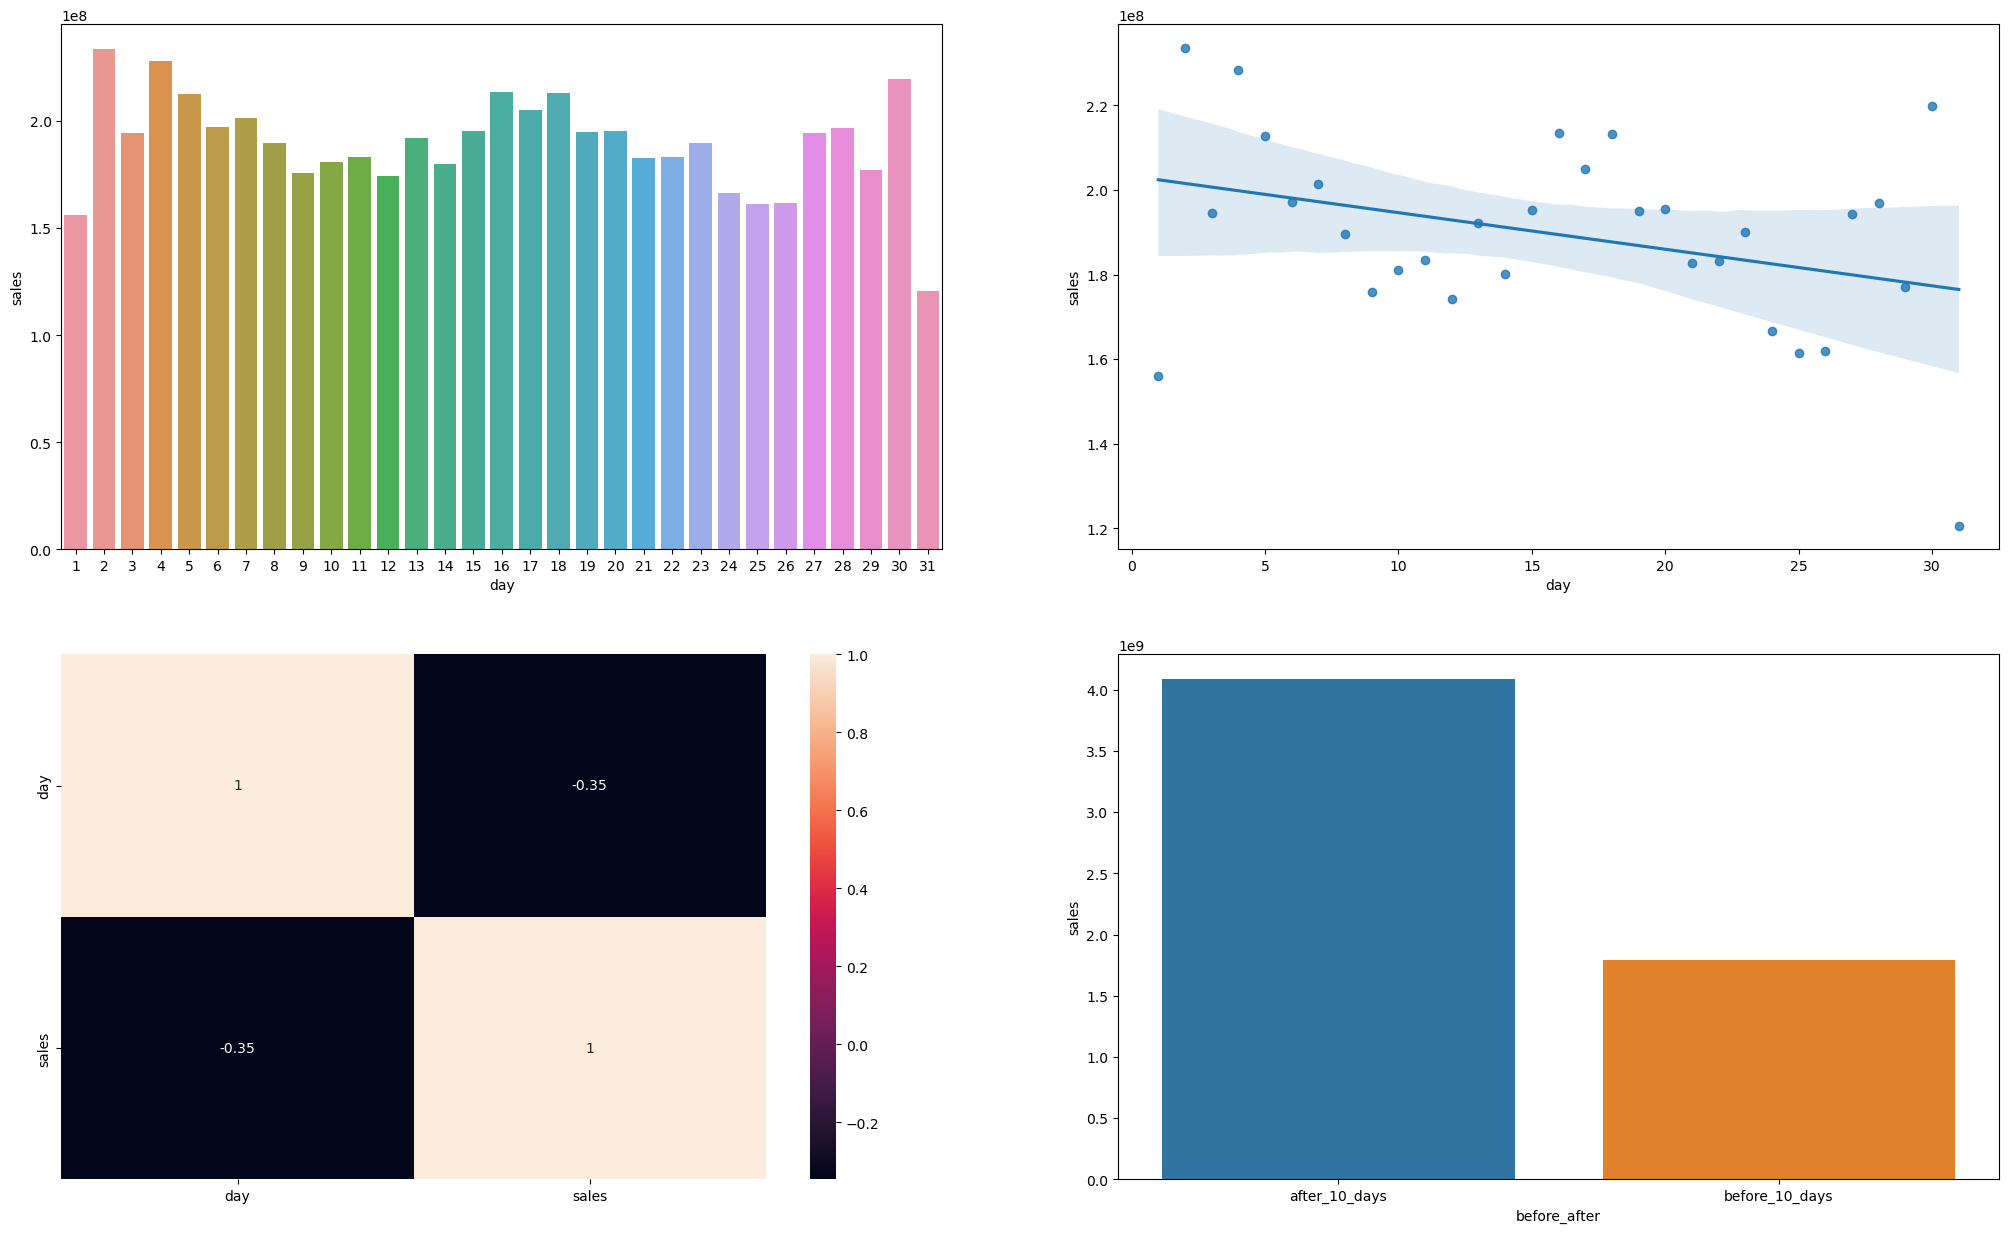

In [111]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.figure(figsize=(25,15))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

#### H11. Stores should sell less on weekends.
#### TRUE -> Store sell less on weekends.

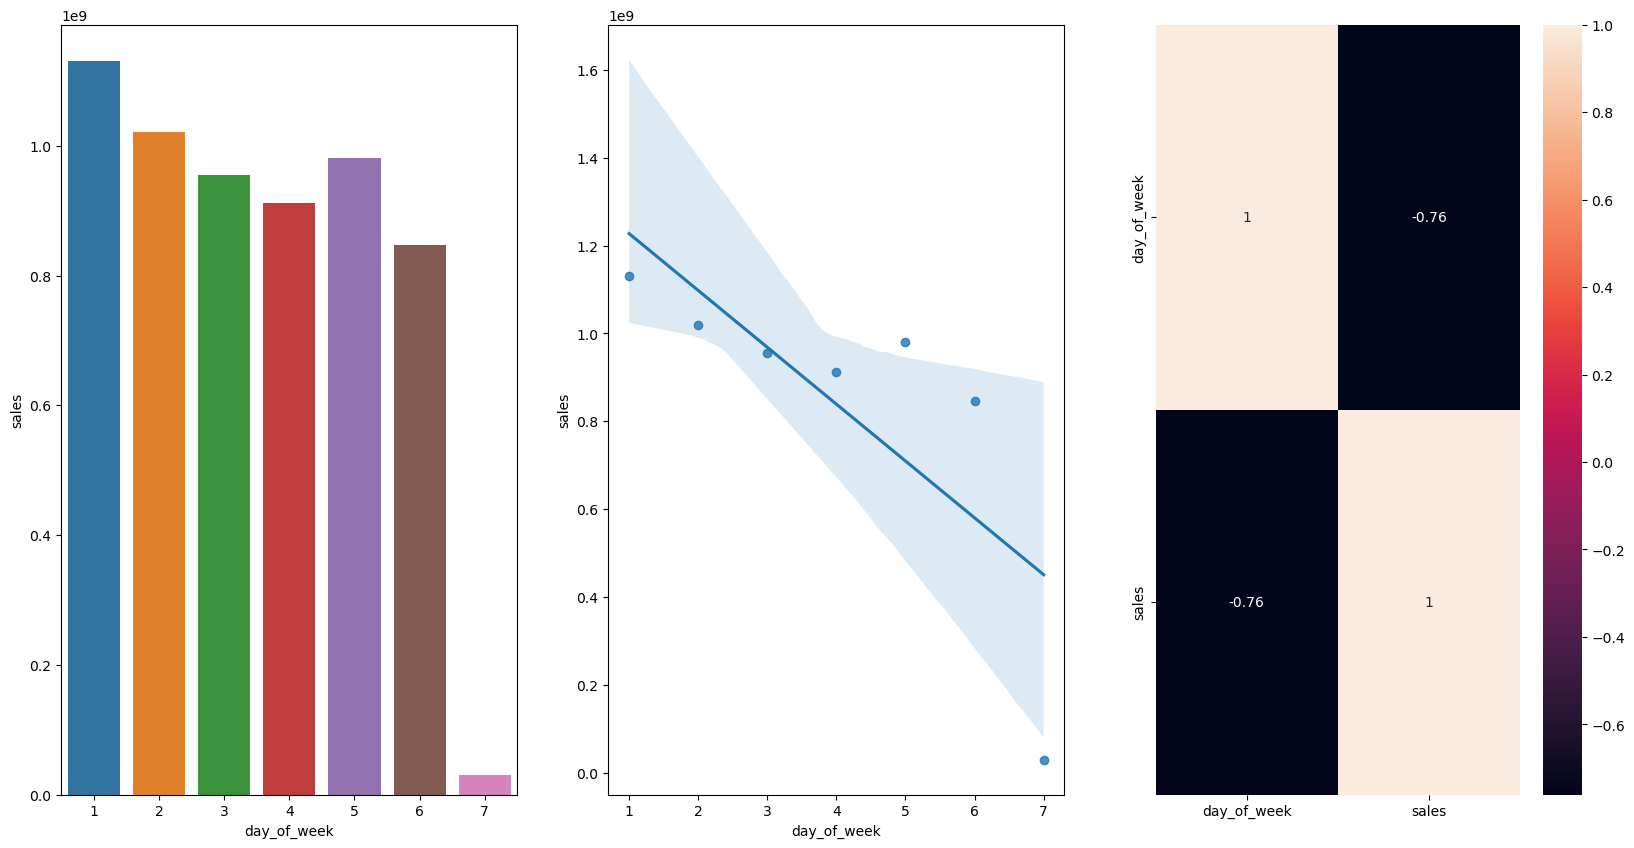

In [112]:

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H12. Stores should sell less during school holidays.
#### TRUE -> Stores SELL LESS during school holidays, except on july and august.

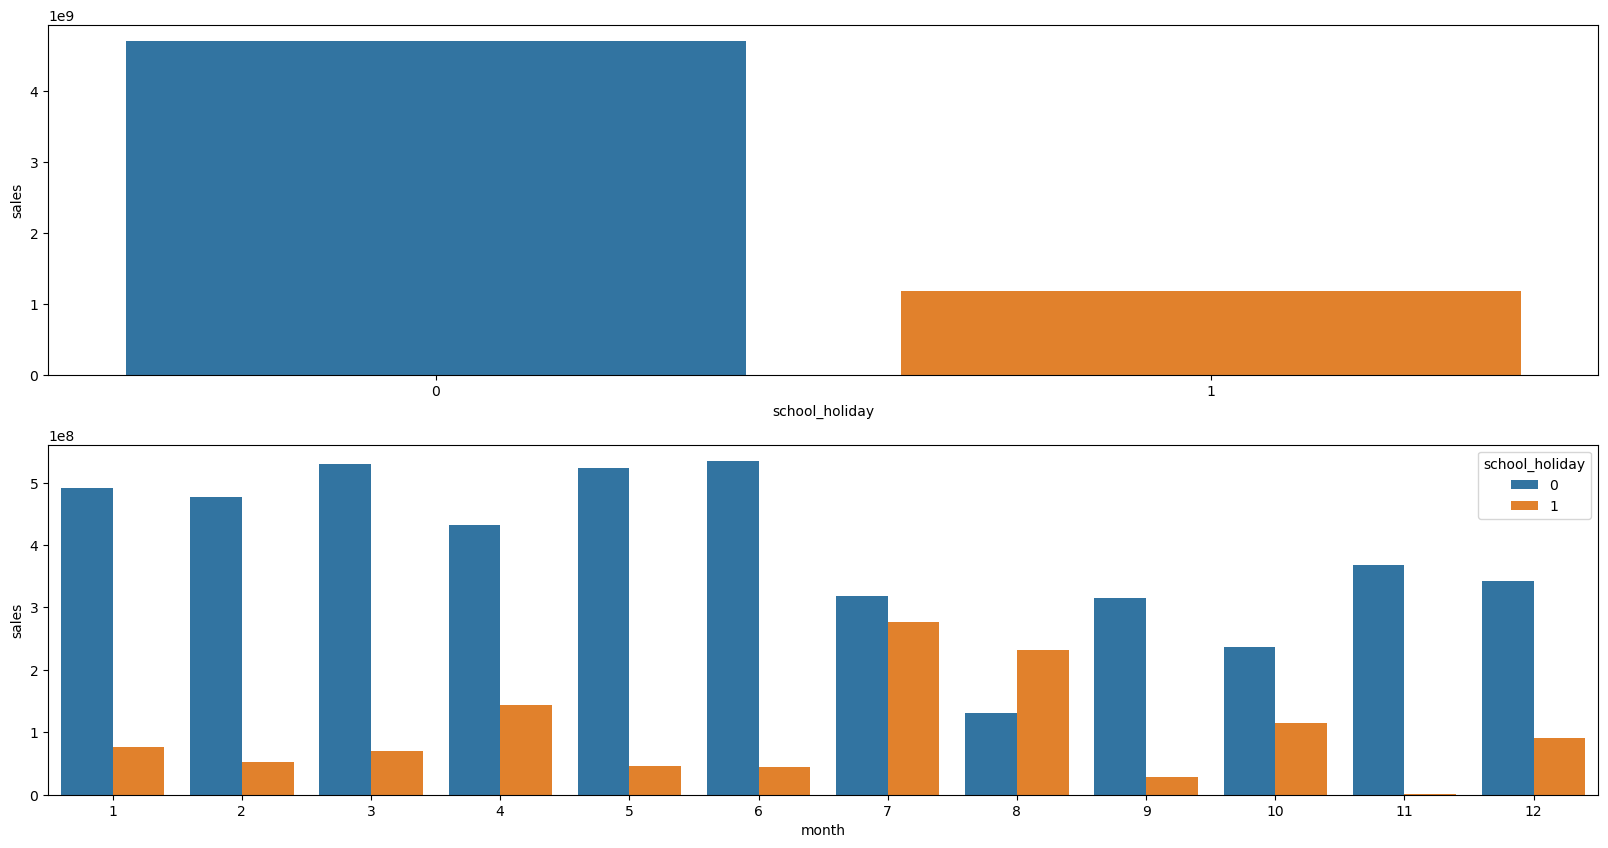

In [113]:
plt.figure(figsize=(20,10))
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

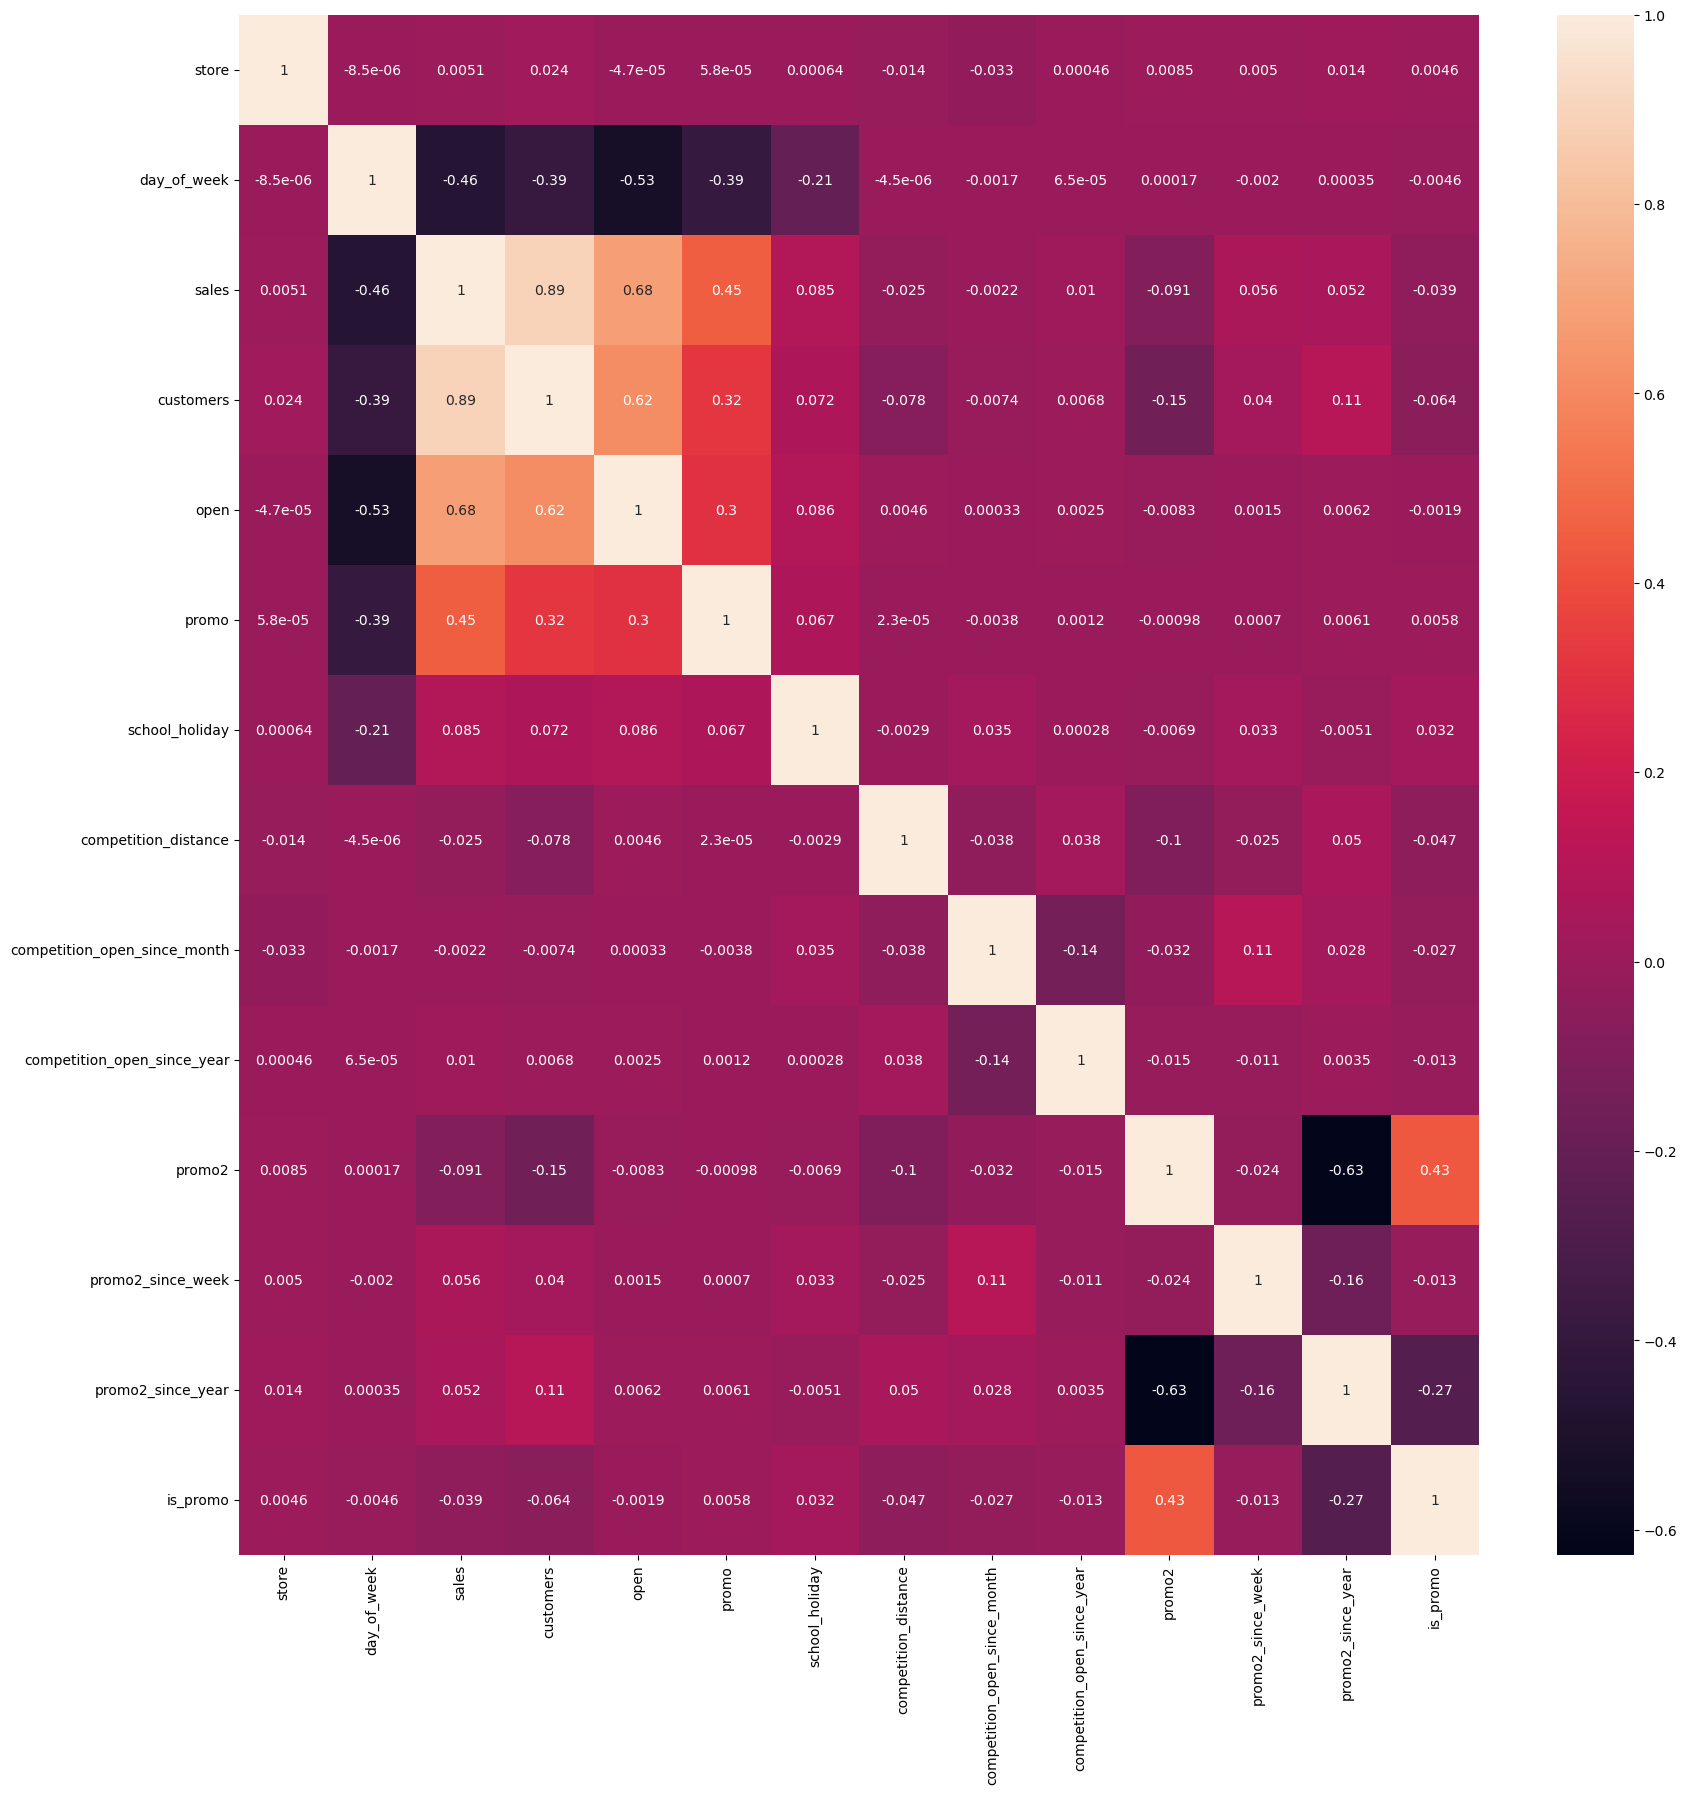

In [114]:
plt.figure(figsize=(20,20))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);


### 4.3.2. Categorical Attributes

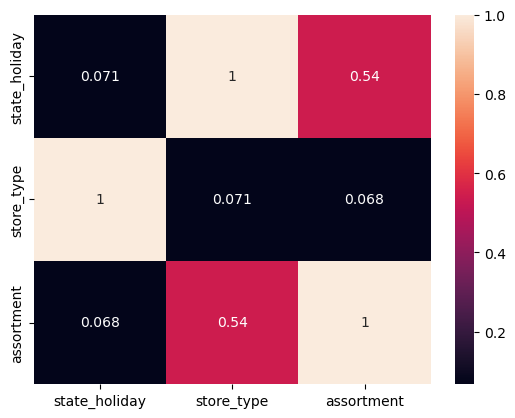

In [115]:
#only categorical data
a = df4.select_dtypes(include='object')

#calculate heatmap
a1 = cramer_v(a['state_holiday'], a['store_type'])
a2 = cramer_v(a['state_holiday'], a['state_holiday'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['store_type'])
a5 = cramer_v(a['store_type'], a['state_holiday'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['store_type'])
a8 = cramer_v(a['assortment'], a['state_holiday'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5.0. Data Preparation

In [116]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [117]:
df5.select_dtypes(include=['int64', 'float64'])

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.0,9,2006,0,1,2013,0,2013,1,1,1,77,0
1016827,733,2,10765,0,1,860.0,10,1999,0,1,2013,0,2013,1,1,1,161,0
1016863,769,2,5035,0,1,840.0,1,2013,1,48,2012,1,2013,1,1,1,0,6
1017042,948,2,4491,0,1,1430.0,1,2013,0,1,2013,0,2013,1,1,1,0,0


In [118]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

<Figure size 1000x1000 with 0 Axes>

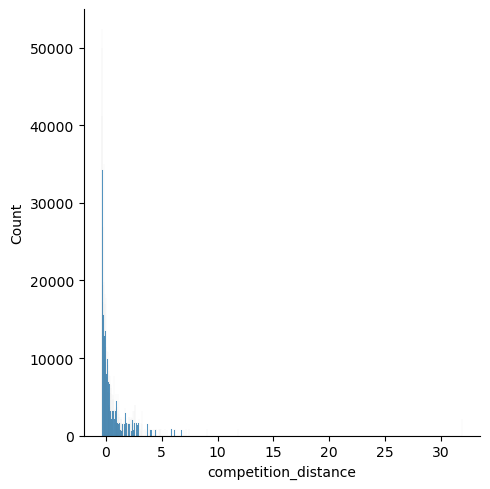

In [119]:
plt.figure(figsize=(10,10))
sns.displot(df5['competition_distance'])

## 5.3. Transformation

## 5.3.1. Encoding

In [120]:
# state_holiday - One Hot Encoding

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding

assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [121]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [122]:
# day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))



# 6.0. Feature Selection

In [123]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [124]:
cols_drop = ['week_of_year', 'day','month','day_of_week','promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [125]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [126]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_train['sales']

print('Training Min Date: {}'.format(x_train['date'].min()))
print('Training Max Date: {}'.format(x_train['date'].max()))

print('\nTest Min Date: {}'.format(x_test['date'].min()))
print('Test Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [137]:
# # training and test dataset - Boruta
# x_train_n = x_train.drop(['date','sales'], axis=1).values
# y_train_n = y_train.values.ravel()


# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta

# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [139]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs=x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [144]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'week_of_year_sin',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta.extend(feat_to_add)

In [146]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']